# Demo PatchTST

Epoch 1: 100%|██████████| 24237/24237 [05:21<00:00, 75.46it/s]


Epoch 1 Loss: 0.0000


Epoch 2: 100%|██████████| 24237/24237 [05:00<00:00, 80.70it/s]


Epoch 2 Loss: 0.0000


Epoch 3: 100%|██████████| 24237/24237 [04:57<00:00, 81.34it/s]


Epoch 3 Loss: 0.0000


Epoch 4: 100%|██████████| 24237/24237 [04:59<00:00, 81.03it/s]


Epoch 4 Loss: 0.0000


Epoch 5: 100%|██████████| 24237/24237 [04:56<00:00, 81.66it/s]


Epoch 5 Loss: 0.0000


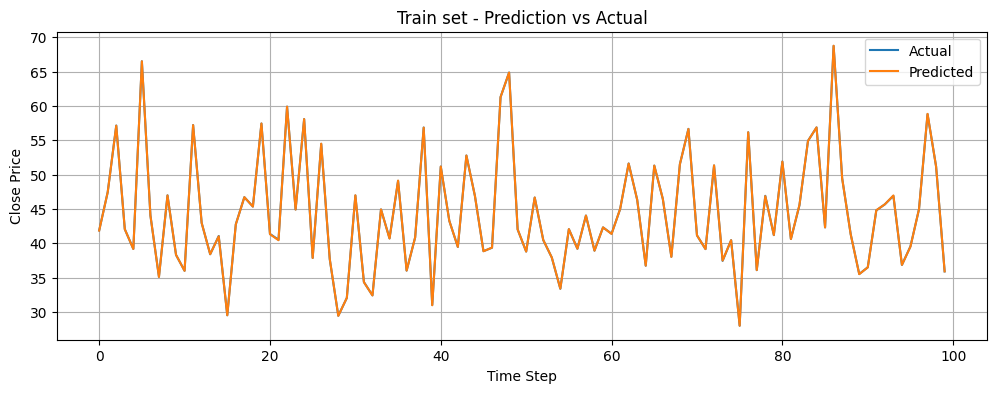

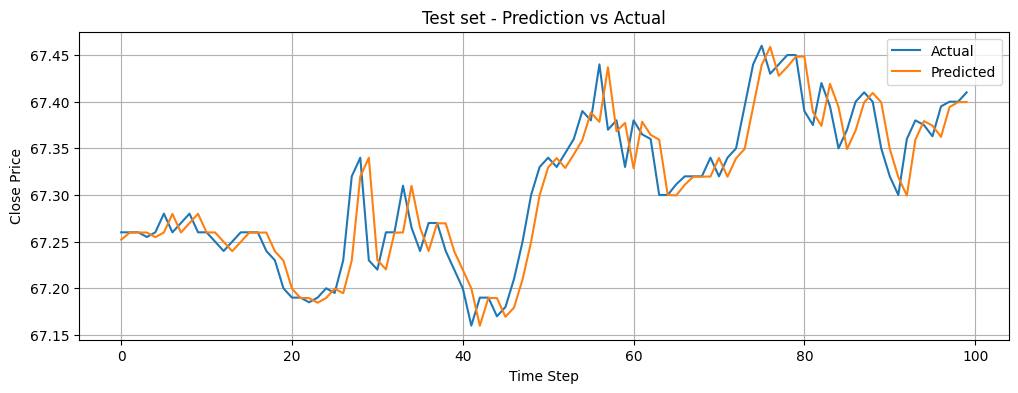

In [ ]:
# --- 1. Thư viện ---
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from transformers import PatchTSTConfig, PatchTSTForPrediction
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 2. Đọc và chuẩn hóa dữ liệu ---
df = pd.read_parquet('/content/drive/MyDrive/TimeSeries/Data/A-MINUTES1.parquet')
series = df['close'].dropna().values.reshape(-1, 1)

# Chia train/test
train_size = int(0.8 * len(series))
train_series = series[:train_size]
test_series = series[train_size:]

# Chuẩn hóa chỉ trên train
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_series)
test_scaled = scaler.transform(test_series)

# --- 3. Dataset ---
class TimeSeriesDataset(Dataset):
    def __init__(self, series, context_length, prediction_length):
        self.series = series
        self.context_length = context_length
        self.prediction_length = prediction_length

    def __len__(self):
        return len(self.series) - self.context_length - self.prediction_length

    def __getitem__(self, idx):
        x = self.series[idx : idx + self.context_length]
        y = self.series[idx + self.context_length : idx + self.context_length + self.prediction_length]
        return {
            'past_values': torch.tensor(x, dtype=torch.float),
            'future_values': torch.tensor(y, dtype=torch.float),
        }

context_length = 60
prediction_length = 1  # 1 phút tiếp theo

train_dataset = TimeSeriesDataset(train_scaled, context_length, prediction_length)
test_dataset = TimeSeriesDataset(test_scaled, context_length, prediction_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- 4. Cấu hình và tạo model ---
config = PatchTSTConfig(
    context_length=context_length,
    prediction_length=prediction_length,
    patch_len=10,
    stride=10,
    d_model=64,
    num_layers=2,
    num_heads=2,
    dropout=0.1,
    target_dim=1,
)
model = PatchTSTForPrediction(config)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# --- 5. Huấn luyện ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

for epoch in range(5):  # tăng số epoch nếu cần
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x = batch['past_values'].to(device)
        y = batch['future_values'].to(device)

        outputs = model(past_values=x)
        pred = outputs.prediction_outputs
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

# --- 6. Hàm dự đoán ---
def predict_and_plot(loader, name="Test"):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            x = batch['past_values'].to(device)
            y = batch['future_values'].to(device)
            output = model(past_values=x).prediction_outputs
            preds.append(output.cpu().numpy())
            trues.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)

    # Inverse scale
    preds_inv = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
    trues_inv = scaler.inverse_transform(trues.reshape(-1, 1)).flatten()

    # Vẽ biểu đồ cho 100 điểm đầu tiên
    plt.figure(figsize=(12, 4))
    plt.plot(trues_inv[:100], label='Actual')
    plt.plot(preds_inv[:100], label='Predicted')
    plt.title(f'{name} set - Prediction vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 7. Trực quan hóa ---
predict_and_plot(train_loader, "Train")
predict_and_plot(test_loader, "Test")


# Code theo Logic của Việt (chưa chạy)

In [ ]:
# --- 1. Thư viện ---
import pandas as pd
import numpy as np
import glob
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import PatchTSTConfig, PatchTSTForPrediction
import matplotlib.pyplot as plt
from tqdm import tqdm


# --- 2. LabelEncoder ---
def fit_label_encoder(parquet_folder, save_path="label_encoder.pkl"):
    files = glob.glob(f"{parquet_folder}/*.parquet")
    tickers = sorted({f.split("/")[-1].split("-")[0] for f in files})
    le = LabelEncoder()
    le.fit(tickers)
    with open(save_path, "wb") as f:
        pickle.dump(le, f)
    return le


# --- 3. Tiền xử lý và chuẩn hóa từng ticker ---
def preprocess_data(parquet_folder, label_encoder, missing_threshold=0.8):
    files = glob.glob(f"{parquet_folder}/*.parquet")
    dfs = []
    for f in files:
        ticker = f.split("/")[-1].split("-")[0]
        if ticker not in label_encoder.classes_:
            continue
        df = pd.read_parquet(f).reset_index().rename(columns={"index": "datetime"})
        df["ticker"] = ticker
        dfs.append(df)

    df_all = pd.concat(dfs)
    df_all["datetime"] = pd.to_datetime(df_all["datetime"])
    df_all["date"] = df_all["datetime"].dt.date
    df_all["ticker_id"] = label_encoder.transform(df_all["ticker"])

    # Chuẩn hóa từng ticker riêng
    scalers = {}
    df_all["scaled_close"] = np.nan
    for ticker in df_all["ticker"].unique():
        mask = df_all["ticker"] == ticker
        scaler = StandardScaler()
        df_all.loc[mask, "scaled_close"] = scaler.fit_transform(df_all.loc[mask, ["close"]])
        scalers[ticker] = scaler

    df_all["close"] = df_all["scaled_close"]
    return df_all.drop(columns=["scaled_close"]), scalers


# --- 4. Tạo sequence ---
def create_sequences(df, window=60):
    X, y, tid = [], [], []
    for ticker_id in df["ticker_id"].unique():
        temp = df[df["ticker_id"] == ticker_id].sort_values("datetime")
        close_vals = temp["close"].values
        for i in range(len(close_vals) - window):
            X.append(close_vals[i:i+window])
            y.append(close_vals[i+window])
            tid.append(ticker_id)
    return np.array(X), np.array(y), np.array(tid)


# --- 5. Chia train/val/test theo thời gian ---
def split_timewise(X, y, tid, val_ratio=0.2, test_ratio=0.2):
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    tid_train, tid_val, tid_test = [], [], []

    for t in np.unique(tid):
        idx = np.where(tid == t)[0]
        if len(idx) < 10: continue
        n_test = int(len(idx) * test_ratio)
        n_val = int((len(idx) - n_test) * val_ratio)

        X_t, y_t = X[idx], y[idx]
        t_t = tid[idx]

        X_train.append(X_t[:-n_test-n_val])
        y_train.append(y_t[:-n_test-n_val])
        tid_train.append(t_t[:-n_test-n_val])

        X_val.append(X_t[-n_test-n_val:-n_test])
        y_val.append(y_t[-n_test-n_val:-n_test])
        tid_val.append(t_t[-n_test-n_val:-n_test])

        X_test.append(X_t[-n_test:])
        y_test.append(y_t[-n_test:])
        tid_test.append(t_t[-n_test:])

    return map(torch.tensor, [np.concatenate(X_train), np.concatenate(X_val), np.concatenate(X_test),
                              np.concatenate(y_train), np.concatenate(y_val), np.concatenate(y_test),
                              np.concatenate(tid_train), np.concatenate(tid_val), np.concatenate(tid_test)])


# --- 6. Dataset PyTorch ---
class MultiTickerDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.float().unsqueeze(-1)  # [N, 60, 1] => thêm chiều đặc trưng
        self.y = y.float().unsqueeze(-1)  # [N, 1]

    def __len__(self): return len(self.x)

    def __getitem__(self, idx):
        return {
            "past_values": self.x[idx],   # shape: [60, 1]
            "future_values": self.y[idx], # shape: [1]
        }



# --- 7. Huấn luyện ---
def train_model(model, train_loader, epochs=5, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            x = batch['past_values'].to(device)
            y = batch['future_values'].to(device)

            out = model(past_values=x).prediction_outputs
            loss = loss_fn(out, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")


# --- 8. Dự đoán và biểu đồ ---
def predict_plot(model, loader, scaler, name="Test"):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            x = batch['past_values'].to(device)
            y = batch['future_values'].to(device)
            out = model(past_values=x).prediction_outputs
            preds.append(out.cpu().numpy())
            trues.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)

    preds_inv = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
    trues_inv = scaler.inverse_transform(trues.reshape(-1, 1)).flatten()

    plt.figure(figsize=(12, 4))
    plt.plot(trues_inv[:100], label='Actual')
    plt.plot(preds_inv[:100], label='Predicted')
    plt.title(f"{name} - Actual vs Predicted")
    plt.legend()
    plt.grid(True)
    plt.show()


# --- 9. Main chạy thử ---
# Load encoder
label_encoder = fit_label_encoder("/content/drive/MyDrive/Draft/TimeSeries/Data")
df_all, scalers = preprocess_data("/content/drive/MyDrive/Draft/TimeSeries/Demo_Data_5", label_encoder)

X, y, tid = create_sequences(df_all, window=60)
X_train, X_val, X_test, y_train, y_val, y_test, _, _, _ = split_timewise(X, y, tid)

train_loader = DataLoader(MultiTickerDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(MultiTickerDataset(X_val, y_val), batch_size=64)
test_loader = DataLoader(MultiTickerDataset(X_test, y_test), batch_size=64)

config = PatchTSTConfig(
    context_length=60,
    prediction_length=1,
    patch_len=10,
    stride=10,
    d_model=64,
    num_layers=2,
    num_heads=2,
    dropout=0.1,
    target_dim=1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PatchTSTForPrediction(config).to(device)

train_model(model, train_loader, epochs=5)
predict_plot(model, test_loader, list(scalers.values())[0], "Test")


Epoch 1:   0%|          | 0/50127 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1:  39%|███▉      | 19718/50127 [03:49<05:53, 85.98it/s]


KeyboardInterrupt: 

In [ ]:
import pandas as pd
df = pd.read_parquet("/content/drive/MyDrive/Draft/TimeSeries/Demo_Data_5/AMZN-MINUTES1.parquet")
df

,open,high,low,close,vol
2010-01-04 17:30:00,136.1500,136.40,135.76,135.870,61657
2010-01-04 17:31:00,135.9399,136.07,135.75,135.770,68212
2010-01-04 17:32:00,135.8680,135.88,135.40,135.400,44408
2010-01-04 17:33:00,135.4050,135.63,135.32,135.320,75774
2010-01-04 17:34:00,135.3400,135.51,135.34,135.385,33723
...,...,...,...,...,...
2020-11-25 23:46:00,3189.3100,3189.31,3189.31,3189.310,100
2020-11-25 23:47:00,3189.1200,3189.74,3189.12,3189.740,300
2020-11-25 23:48:00,3187.3350,3187.34,3185.00,3185.000,300
2020-11-25 23:49:00,3184.7600,3184.98,3184.76,3184.980,300


Epoch 1: 100%|██████████| 24236/24236 [04:39<00:00, 86.73it/s]


Epoch 1 Loss: 0.0003


Epoch 2: 100%|██████████| 24236/24236 [04:39<00:00, 86.71it/s]


Epoch 2 Loss: 0.0003


Epoch 3: 100%|██████████| 24236/24236 [04:37<00:00, 87.35it/s]


Epoch 3 Loss: 0.0003


Epoch 4: 100%|██████████| 24236/24236 [04:36<00:00, 87.62it/s]


Epoch 4 Loss: 0.0003


Epoch 5: 100%|██████████| 24236/24236 [05:02<00:00, 80.05it/s]


Epoch 5 Loss: 0.0003


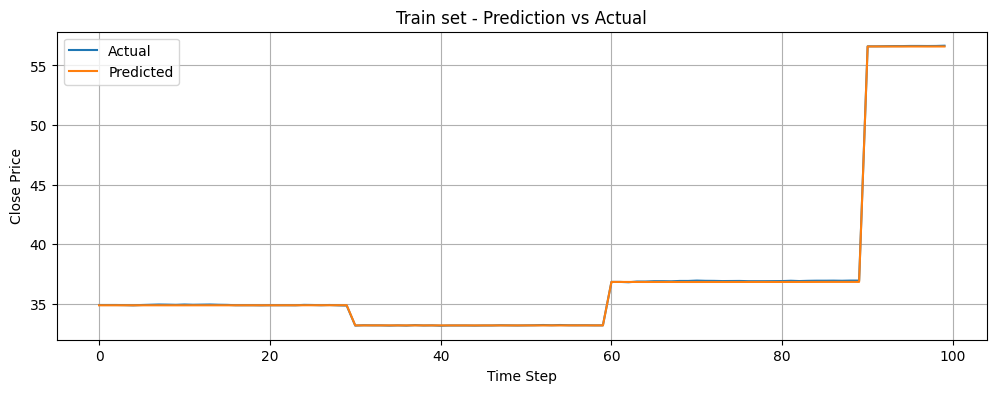

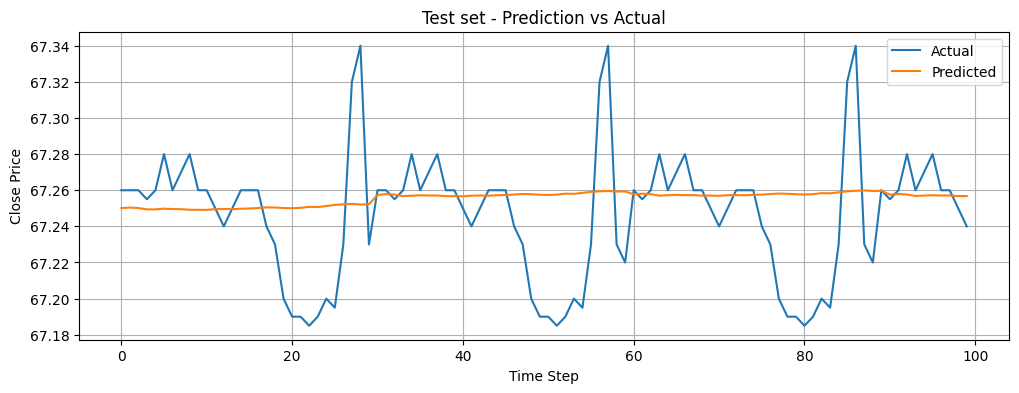

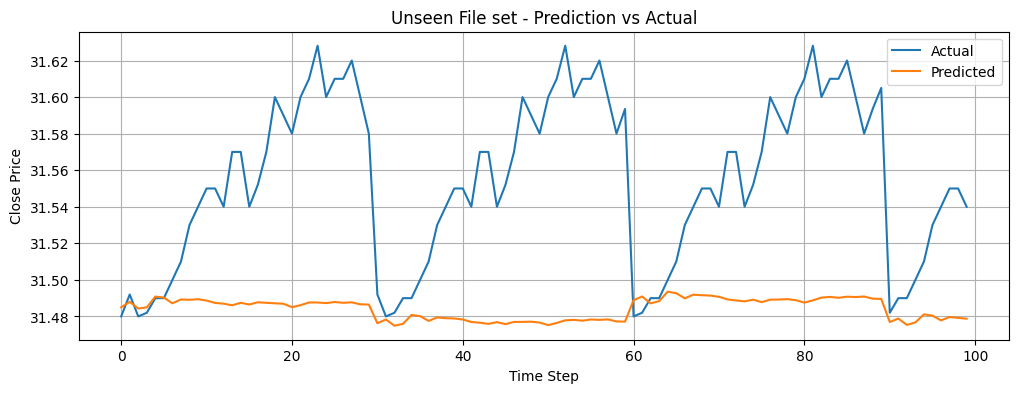

In [ ]:
# --- 1. Thư viện ---
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from transformers import PatchTSTConfig, PatchTSTForPrediction
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 2. Đọc và chuẩn hóa dữ liệu huấn luyện ---
df = pd.read_parquet('/content/drive/MyDrive/Draft/TimeSeries/Data/A-MINUTES1.parquet')
series = df['close'].dropna().values.reshape(-1, 1)

# Chia train/test
train_size = int(0.8 * len(series))
train_series = series[:train_size]
test_series = series[train_size:]

# Chuẩn hóa chỉ trên train
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_series)
test_scaled = scaler.transform(test_series)

# --- 3. Dataset ---
class TimeSeriesDataset(Dataset):
    def __init__(self, series, context_length, prediction_length):
        self.series = series
        self.context_length = context_length
        self.prediction_length = prediction_length

    def __len__(self):
        return len(self.series) - self.context_length - self.prediction_length

    def __getitem__(self, idx):
        x = self.series[idx : idx + self.context_length]
        y = self.series[idx + self.context_length : idx + self.context_length + self.prediction_length]
        return {
            'past_values': torch.tensor(x, dtype=torch.float),
            'future_values': torch.tensor(y, dtype=torch.float),
        }

context_length = 60
prediction_length = 30

train_dataset = TimeSeriesDataset(train_scaled, context_length, prediction_length)
test_dataset = TimeSeriesDataset(test_scaled, context_length, prediction_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- 4. Cấu hình và tạo model ---
config = PatchTSTConfig(
    context_length=context_length,
    prediction_length=prediction_length,
    patch_len=10,
    stride=10,
    d_model=64,
    num_layers=2,
    num_heads=2,
    dropout=0.1,
    target_dim=1,
)
model = PatchTSTForPrediction(config)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# --- 5. Huấn luyện ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x = batch['past_values'].to(device)
        y = batch['future_values'].to(device)

        outputs = model(past_values=x)
        pred = outputs.prediction_outputs
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

# --- 6. Hàm dự đoán ---
def predict_and_plot(loader, name="Test"):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            x = batch['past_values'].to(device)
            y = batch['future_values'].to(device)
            output = model(past_values=x).prediction_outputs
            preds.append(output.cpu().numpy())
            trues.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)

    preds_inv = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
    trues_inv = scaler.inverse_transform(trues.reshape(-1, 1)).flatten()

    plt.figure(figsize=(12, 4))
    plt.plot(trues_inv[:100], label='Actual')
    plt.plot(preds_inv[:100], label='Predicted')
    plt.title(f'{name} set - Prediction vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 7. Trực quan hóa ---
predict_and_plot(train_loader, "Train")
predict_and_plot(test_loader, "Test")

# --- 8. Dự đoán trên file chưa huấn luyện ---
def predict_on_new_file(parquet_path, name="External"):
    df_new = pd.read_parquet(parquet_path)
    new_series = df_new['close'].dropna().values.reshape(-1, 1)
    new_scaled = scaler.transform(new_series)  # dùng scaler đã fit từ train
    new_dataset = TimeSeriesDataset(new_scaled, context_length, prediction_length)
    new_loader = DataLoader(new_dataset, batch_size=32, shuffle=False)
    predict_and_plot(new_loader, name)

# Gọi thử:
# predict_on_new_file('/content/drive/MyDrive/Draft/TimeSeries/Demo_Data_5/GOOGL-MINUTES1.parquet', name="Unseen File")
predict_on_new_file('/content/drive/MyDrive/Draft/TimeSeries/Data/A-MINUTES1.parquet', name="Unseen File")


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def create_model_with_prediction_length(pred_len):
    cfg = PatchTSTConfig(
        context_length=context_length,
        prediction_length=pred_len,
        patch_len=10,
        stride=10,
        d_model=64,
        num_layers=2,
        num_heads=2,
        dropout=0.1,
        target_dim=1,
    )
    m = PatchTSTForPrediction(cfg).to(device)
    m.load_state_dict(model.state_dict())  # copy trọng số đã huấn luyện nếu phù hợp
    return m


In [ ]:
def predict_future(series_raw, label, prediction_length):
    # Tạo mô hình mới với prediction_length tương ứng
    future_model = create_model_with_prediction_length(prediction_length)
    future_model.eval()

    # Lấy dữ liệu đầu vào
    series_scaled = scaler.transform(series_raw.reshape(-1, 1))
    context = series_scaled[-context_length:].reshape(1, context_length, 1)
    context_tensor = torch.tensor(context, dtype=torch.float).to(device)

    with torch.no_grad():
        output = future_model(past_values=context_tensor)
        preds = output.prediction_outputs.cpu().numpy().reshape(-1, 1)

    # Inverse scale
    preds_inv = scaler.inverse_transform(preds).flatten()

    # Vẽ
    plt.figure(figsize=(12, 4))
    plt.plot(preds_inv, label=f"Predicted {label}")
    plt.title(f"{label} Forecast")
    plt.xlabel("Minute")
    plt.ylabel("Close Price")
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
df_full = pd.read_parquet('/content/drive/MyDrive/Draft/TimeSeries/Data/A-MINUTES1.parquet')
series_full = df_full['close'].dropna().values
predict_future(series_full, "3 Hours", prediction_length=180)
predict_future(series_full, "3 Days", prediction_length=4320)
predict_future(series_full, "3 Months", prediction_length=129600)
predict_future(series_full, "3 Years", prediction_length=1576800)


RuntimeError: Error(s) in loading state_dict for PatchTSTForPrediction:
	size mismatch for head.projection.weight: copying a param with shape torch.Size([30, 64]) from checkpoint, the shape in current model is torch.Size([180, 64]).
	size mismatch for head.projection.bias: copying a param with shape torch.Size([30]) from checkpoint, the shape in current model is torch.Size([180]).

Predicting: 100%|██████████| 180/180 [00:00<00:00, 292.91it/s]


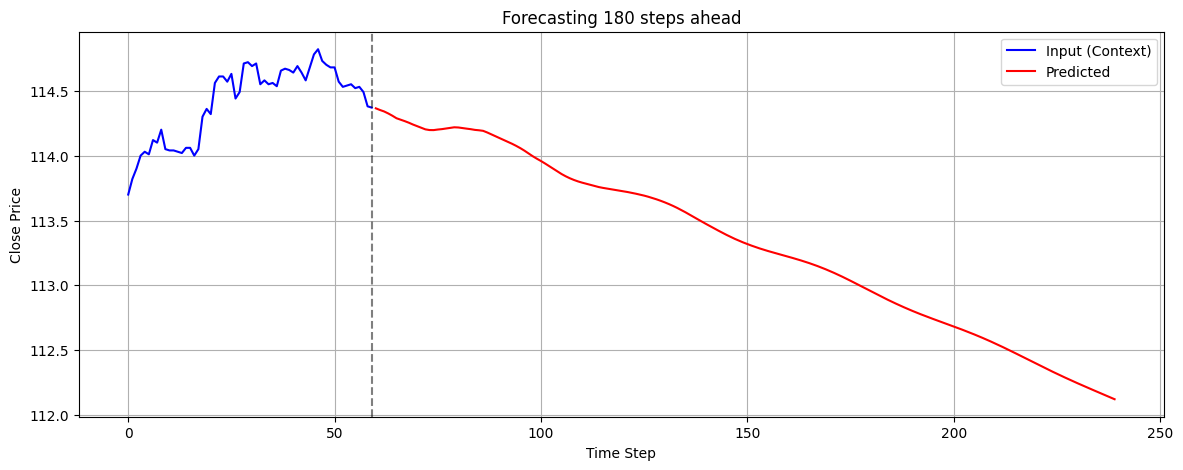

Predicting: 100%|██████████| 4320/4320 [00:16<00:00, 256.16it/s]


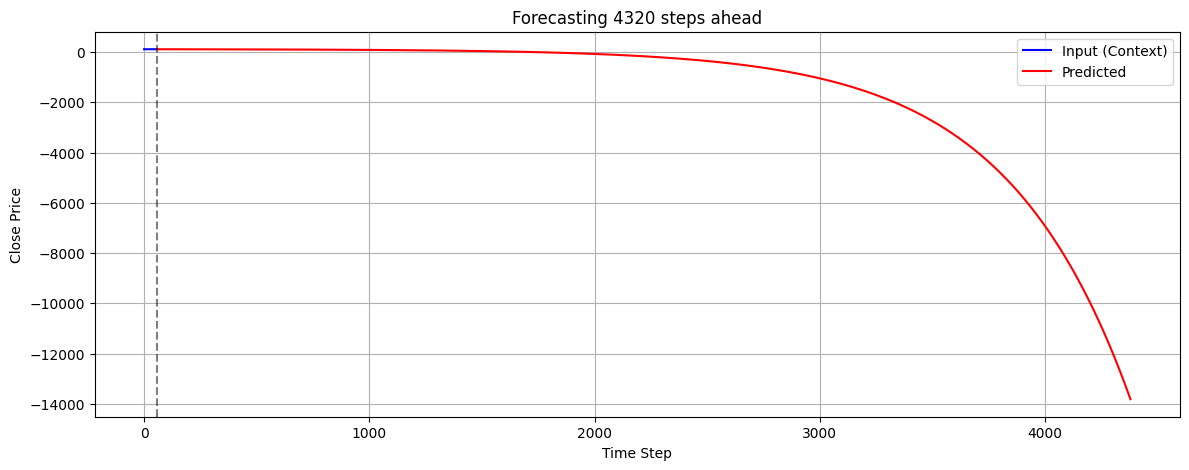

array([   114.36441686,    114.35164249,    114.3404265 , ...,
       -13767.42997088, -13792.44448388, -13817.50394861])

In [ ]:
def predict_autoregressive(model, series_raw, total_steps, context_length, scaler, plot_actual=True):
    model.eval()
    device = next(model.parameters()).device

    # Chuẩn hóa toàn bộ chuỗi gốc
    series_scaled = scaler.transform(series_raw.reshape(-1, 1))

    # Lấy context cuối cùng
    context = list(series_scaled[-context_length:].flatten())
    preds = []

    for _ in tqdm(range(total_steps), desc="Predicting"):
        input_seq = torch.tensor(context[-context_length:], dtype=torch.float).reshape(1, context_length, 1).to(device)
        with torch.no_grad():
            output = model(past_values=input_seq)
            pred = output.prediction_outputs[0, 0, 0].cpu().item()
        preds.append(pred)
        context.append(pred)

    # Inverse scale
    context_inv = scaler.inverse_transform(np.array(context[:context_length]).reshape(-1, 1)).flatten()
    preds_inv = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

    # Nếu có actual để so sánh
    actual_inv = None
    if plot_actual and len(series_raw) >= context_length + total_steps:
        actual_inv = series_raw[-context_length: -context_length + total_steps]

    # Vẽ biểu đồ
    # Vẽ biểu đồ
    plt.figure(figsize=(14, 5))
    plt.plot(range(context_length), context_inv, label='Input (Context)', color='blue')
    if actual_inv is not None and len(actual_inv) == total_steps:
        plt.plot(range(context_length, context_length + total_steps), actual_inv, label='Actual', color='green')
    plt.plot(range(context_length, context_length + total_steps), preds_inv, label='Predicted', color='red')
    plt.axvline(context_length - 1, color='black', linestyle='--', alpha=0.5)
    plt.title(f'Forecasting {total_steps} steps ahead')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()


    return preds_inv


# Dự đoán 3 giờ = 180 phút
predict_autoregressive(model, series_full, total_steps=180, context_length=context_length, scaler=scaler)

# Dự đoán 3 ngày = 3*24*60 = 4320 phút
predict_autoregressive(model, series_full, total_steps=4320, context_length=context_length, scaler=scaler)

# Dự đoán 3 tháng = ~90 ngày = 129600 phút
# Dự đoán 3 năm = ~1095 ngày = 1576800 phút (rất dài, có thể giảm nếu RAM/GPU yếu)


Predicting: 100%|██████████| 180/180 [00:01<00:00, 107.42it/s]


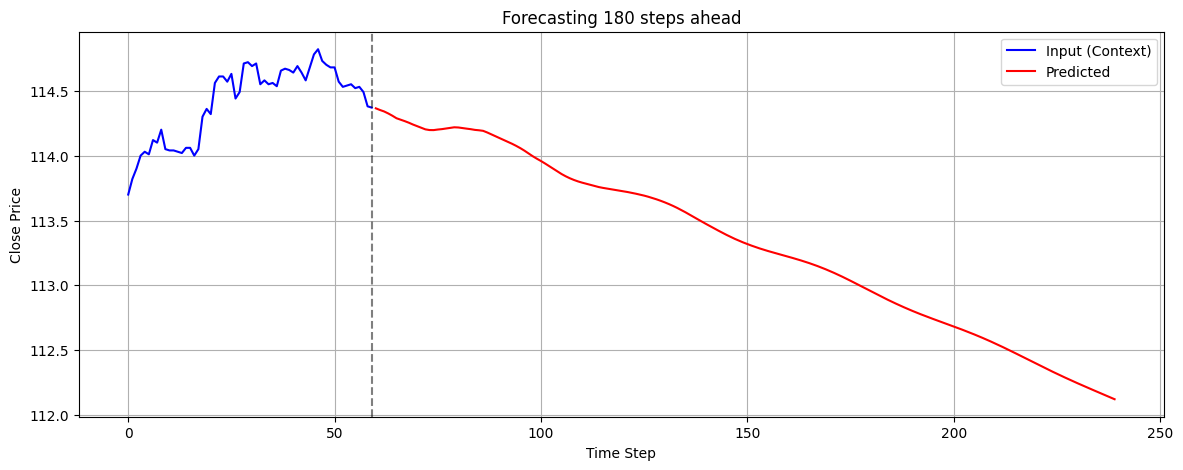

Predicting: 100%|██████████| 4320/4320 [00:16<00:00, 268.65it/s]


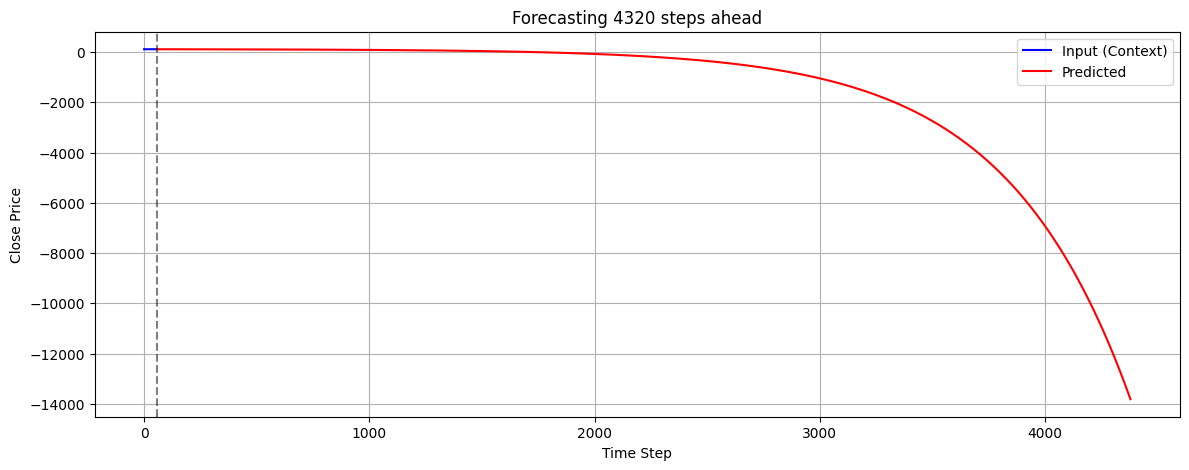

array([   114.36441686,    114.35164249,    114.3404265 , ...,
       -13767.42997088, -13792.44448388, -13817.50394861])

In [ ]:
def predict_autoregressive(model, series_raw, total_steps, context_length, scaler, plot_actual=True):
    model.eval()
    device = next(model.parameters()).device

    # Chuẩn hóa toàn bộ chuỗi gốc
    series_scaled = scaler.transform(series_raw.reshape(-1, 1))

    # Lấy context cuối cùng
    context = list(series_scaled[-context_length:].flatten())
    preds = []

    for _ in tqdm(range(total_steps), desc="Predicting"):
        input_seq = torch.tensor(context[-context_length:], dtype=torch.float).reshape(1, context_length, 1).to(device)
        with torch.no_grad():
            output = model(past_values=input_seq)
            pred = output.prediction_outputs[0, 0, 0].cpu().item()
        preds.append(pred)
        context.append(pred)

    # Inverse scale
    context_inv = scaler.inverse_transform(np.array(context[:context_length]).reshape(-1, 1)).flatten()
    preds_inv = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

    # Lấy đoạn actual nếu có đủ dữ liệu
    actual_inv = None
    actual_start = len(series_raw) - context_length
    actual_end = actual_start + total_steps
    if plot_actual and actual_end <= len(series_raw):
        actual_inv = series_raw[actual_start:actual_end]

    # Vẽ biểu đồ
    plt.figure(figsize=(14, 5))
    plt.plot(range(context_length), context_inv, label='Input (Context)', color='blue')
    if actual_inv is not None:
        plt.plot(range(context_length, context_length + len(actual_inv)), actual_inv, label='Actual', color='green')
    plt.plot(range(context_length, context_length + total_steps), preds_inv, label='Predicted', color='red')
    plt.axvline(context_length - 1, color='black', linestyle='--', alpha=0.5)
    plt.title(f'Forecasting {total_steps} steps ahead')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return preds_inv



# Dự đoán 3 giờ = 180 phút
predict_autoregressive(model, series_full, total_steps=180, context_length=context_length, scaler=scaler)

# Dự đoán 3 ngày = 3*24*60 = 4320 phút
predict_autoregressive(model, series_full, total_steps=4320, context_length=context_length, scaler=scaler)

# Dự đoán 3 tháng = ~90 ngày = 129600 phút
# Dự đoán 3 năm = ~1095 ngày = 1576800 phút (rất dài, có thể giảm nếu RAM/GPU yếu)


In [ ]:
def predict_autoregressive(model, series_raw, total_steps, context_length, scaler, start_pos=None, plot_actual=True):
    model.eval()
    device = next(model.parameters()).device

    # Nếu không truyền start_pos thì mặc định là cuối chuỗi
    if start_pos is None:
        start_pos = len(series_raw) - context_length

    # Đảm bảo không vượt ra ngoài giới hạn
    if start_pos < 0 or start_pos + context_length + total_steps > len(series_raw):
        raise ValueError("start_pos + context_length + total_steps vượt quá độ dài chuỗi")

    # Chuẩn hóa toàn bộ chuỗi
    series_scaled = scaler.transform(series_raw.reshape(-1, 1))

    # Lấy context và actual từ vị trí chỉ định
    context = list(series_scaled[start_pos: start_pos + context_length].flatten())
    preds = []

    for _ in tqdm(range(total_steps), desc="Predicting"):
        input_seq = torch.tensor(context[-context_length:], dtype=torch.float).reshape(1, context_length, 1).to(device)
        with torch.no_grad():
            output = model(past_values=input_seq)
            pred = output.prediction_outputs[0, 0, 0].cpu().item()
        preds.append(pred)
        context.append(pred)

    # Inverse scale
    context_inv = scaler.inverse_transform(np.array(context[:context_length]).reshape(-1, 1)).flatten()
    preds_inv = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    actual_inv = series_raw[start_pos + context_length: start_pos + context_length + total_steps]

    # Vẽ biểu đồ
    plt.figure(figsize=(14, 5))
    plt.plot(range(context_length), context_inv, label='Input (Context)', color='blue')
    if plot_actual:
        plt.plot(range(context_length, context_length + total_steps), actual_inv, label='Actual', color='green')
    plt.plot(range(context_length, context_length + total_steps), preds_inv, label='Predicted', color='red')
    plt.axvline(context_length - 1, color='black', linestyle='--', alpha=0.5)
    plt.title(f'Forecasting {total_steps} steps ahead from pos {start_pos}')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return preds_inv


Predicting: 100%|██████████| 4320/4320 [00:16<00:00, 262.31it/s]


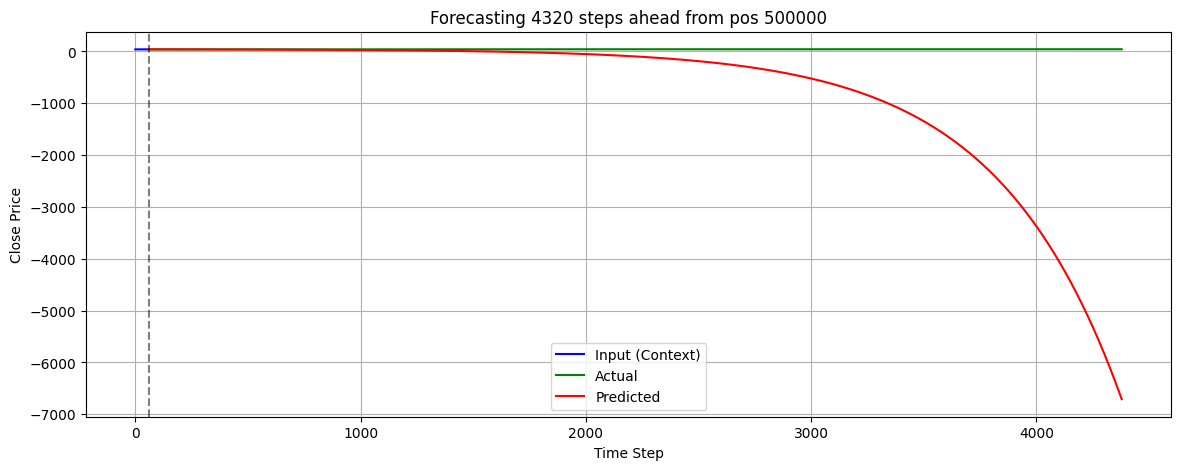

array([   39.71497645,    39.71127419,    39.70727616, ...,
       -6685.74649696, -6697.864921  , -6710.00525902])

In [ ]:
predict_autoregressive(
    model,
    series_full,
    total_steps=4320,
    context_length=context_length,
    scaler=scaler,
    start_pos=500000  # lấy context từ giữa chuỗi
)


Predicting: 100%|██████████| 4320/4320 [00:16<00:00, 267.37it/s]


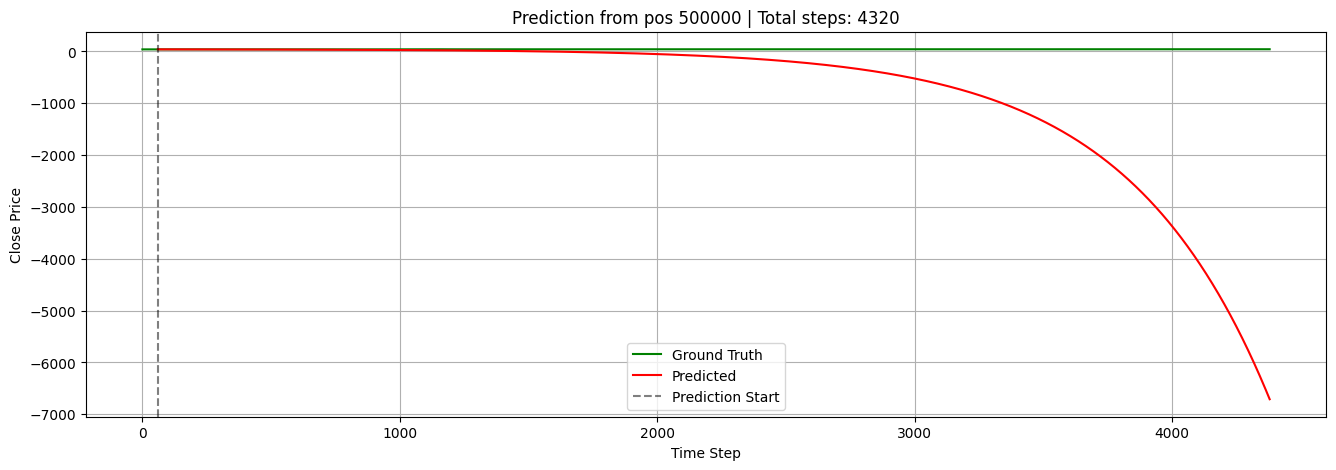

array([   39.71497645,    39.71127419,    39.70727616, ...,
       -6685.74649696, -6697.864921  , -6710.00525902])

In [ ]:
def predict_autoregressive(model, series_raw, total_steps, context_length, scaler, start_pos=None, plot_actual=True):
    model.eval()
    device = next(model.parameters()).device

    # Mặc định lấy từ gần cuối chuỗi
    if start_pos is None:
        start_pos = len(series_raw) - (context_length + total_steps)

    # Kiểm tra độ dài hợp lệ
    if start_pos < 0 or start_pos + context_length + total_steps > len(series_raw):
        raise ValueError("start_pos + context_length + total_steps vượt quá độ dài chuỗi")

    # Chuẩn hóa chuỗi
    series_scaled = scaler.transform(series_raw.reshape(-1, 1))

    # Lấy context và actual từ start_pos
    context = list(series_scaled[start_pos: start_pos + context_length].flatten())
    preds = []

    for _ in tqdm(range(total_steps), desc="Predicting"):
        input_seq = torch.tensor(context[-context_length:], dtype=torch.float).reshape(1, context_length, 1).to(device)
        with torch.no_grad():
            output = model(past_values=input_seq)
            pred = output.prediction_outputs[0, 0, 0].cpu().item()
        preds.append(pred)
        context.append(pred)

    # Chuẩn bị cho vẽ
    full_len = context_length + total_steps
    full_input = series_raw[start_pos: start_pos + context_length + total_steps]
    preds_only = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

    # Vẽ biểu đồ toàn bộ đoạn test
    plt.figure(figsize=(16, 5))
    plt.plot(range(full_len), full_input, label='Ground Truth', color='green')
    plt.plot(range(context_length, context_length + total_steps), preds_only, label='Predicted', color='red')
    plt.axvline(context_length - 1, color='black', linestyle='--', alpha=0.5, label='Prediction Start')
    plt.title(f"Prediction from pos {start_pos} | Total steps: {total_steps}")
    plt.xlabel("Time Step")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    return preds_only
# Dự đoán 3 ngày từ giữa chuỗi
predict_autoregressive(
    model,
    series_raw=series_full,
    total_steps=4320,
    context_length=context_length,
    scaler=scaler,
    start_pos=500000  # ví dụ giữa chuỗi
)


Epoch 1: 100%|██████████| 24236/24236 [04:40<00:00, 86.46it/s]


Epoch 1 Loss: 0.0003


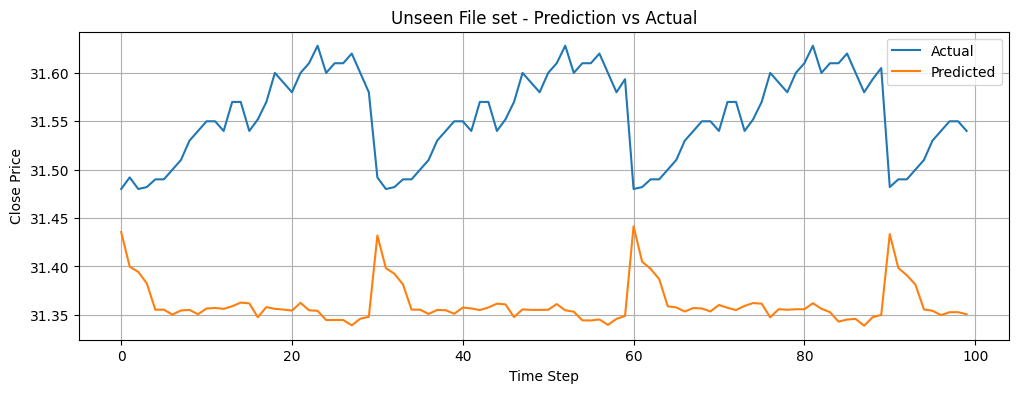

Epoch 2: 100%|██████████| 24236/24236 [04:41<00:00, 86.00it/s]


Epoch 2 Loss: 0.0003


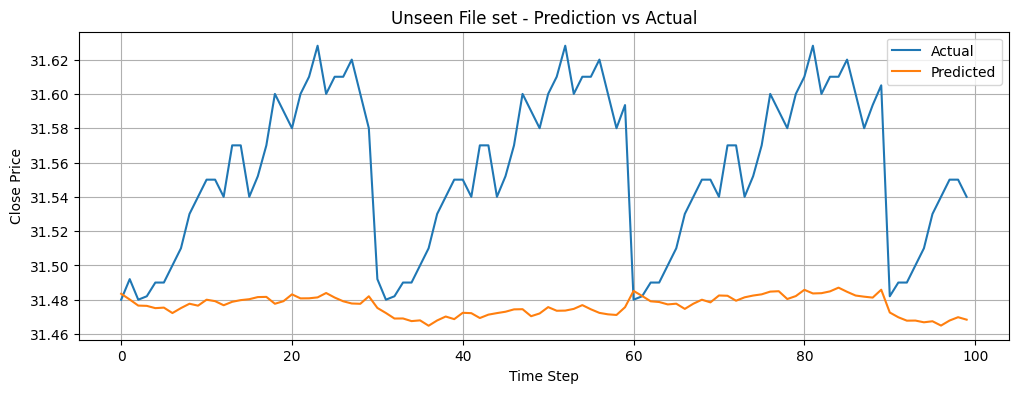

Epoch 3: 100%|██████████| 24236/24236 [04:44<00:00, 85.22it/s]


Epoch 3 Loss: 0.0003


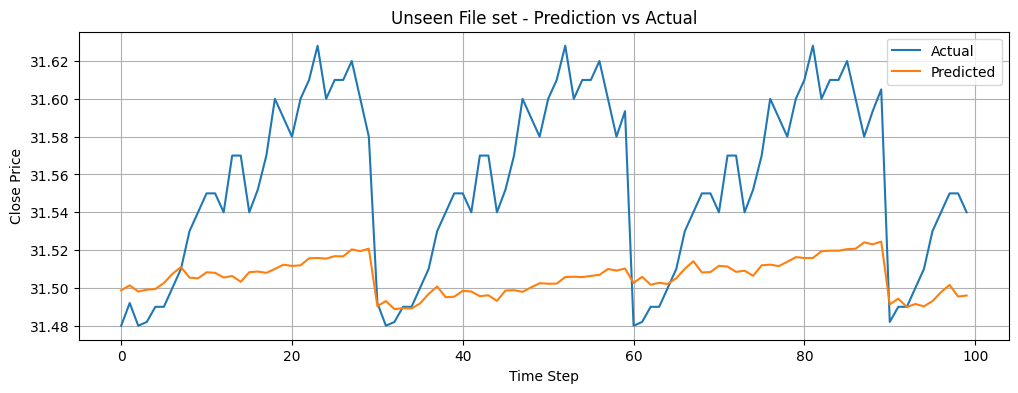

Epoch 4: 100%|██████████| 24236/24236 [04:44<00:00, 85.13it/s]


Epoch 4 Loss: 0.0003


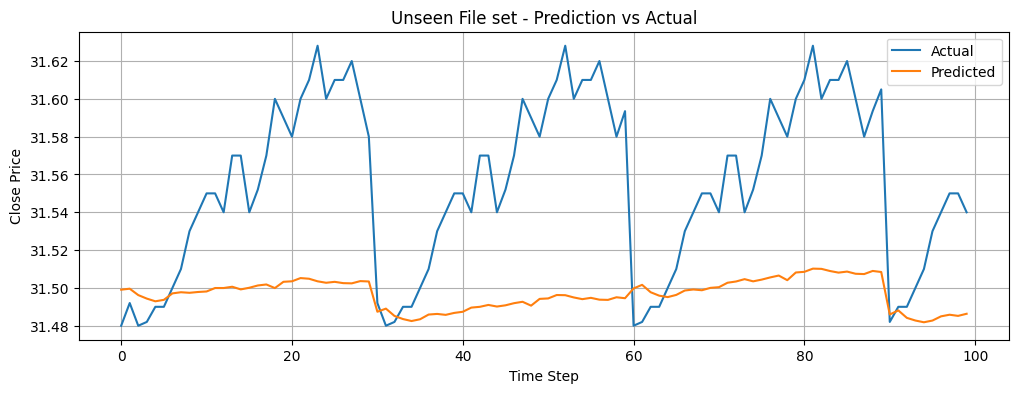

Epoch 5: 100%|██████████| 24236/24236 [04:45<00:00, 84.90it/s]


Epoch 5 Loss: 0.0003


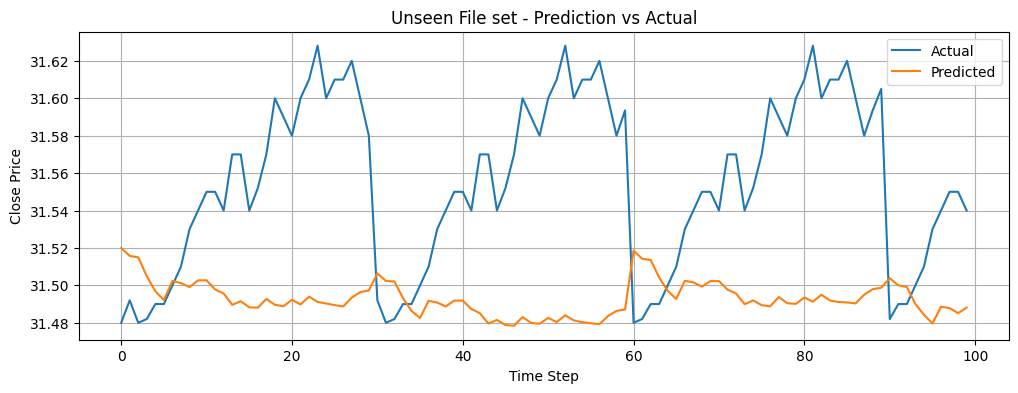

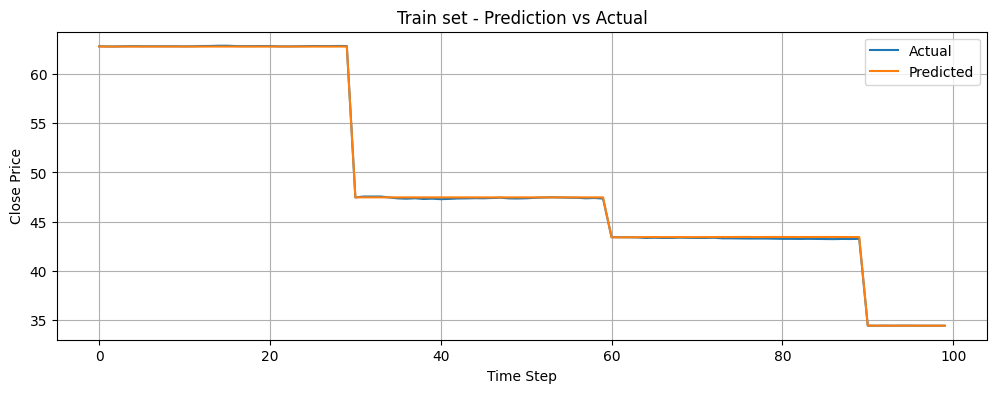

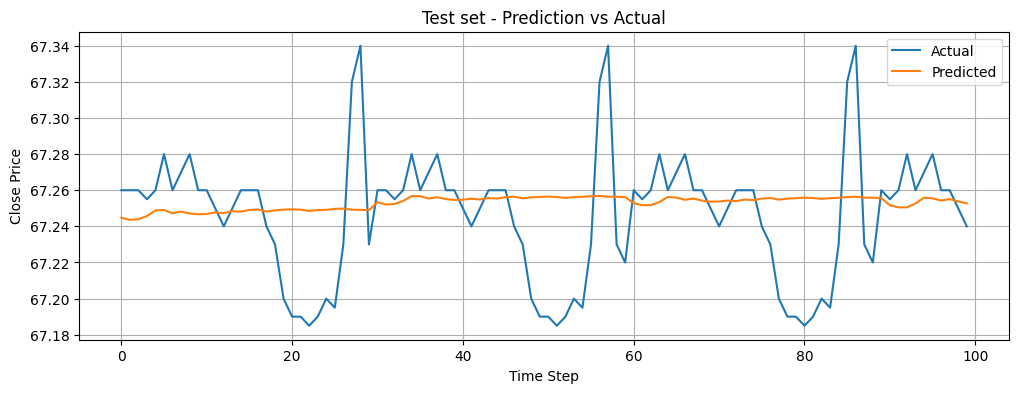

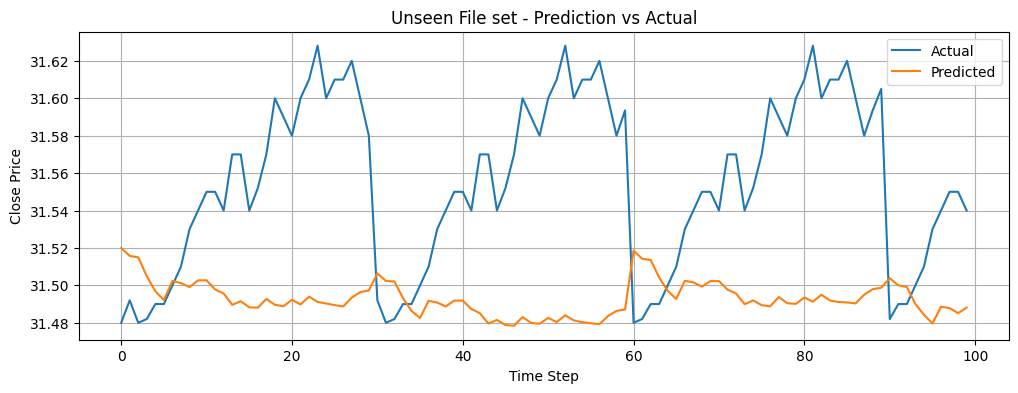

In [ ]:
# --- 1. Thư viện ---
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from transformers import PatchTSTConfig, PatchTSTForPrediction
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 2. Đọc và chuẩn hóa dữ liệu huấn luyện ---
df = pd.read_parquet('/content/drive/MyDrive/Draft/TimeSeries/Data/A-MINUTES1.parquet')
series = df['close'].dropna().values.reshape(-1, 1)

# Chia train/test
train_size = int(0.8 * len(series))
train_series = series[:train_size]
test_series = series[train_size:]

# Chuẩn hóa chỉ trên train
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_series)
test_scaled = scaler.transform(test_series)

# --- 3. Dataset ---
class TimeSeriesDataset(Dataset):
    def __init__(self, series, context_length, prediction_length):
        self.series = series
        self.context_length = context_length
        self.prediction_length = prediction_length

    def __len__(self):
        return len(self.series) - self.context_length - self.prediction_length

    def __getitem__(self, idx):
        x = self.series[idx : idx + self.context_length]
        y = self.series[idx + self.context_length : idx + self.context_length + self.prediction_length]
        return {
            'past_values': torch.tensor(x, dtype=torch.float),
            'future_values': torch.tensor(y, dtype=torch.float),
        }

context_length = 60
prediction_length = 30

train_dataset = TimeSeriesDataset(train_scaled, context_length, prediction_length)
test_dataset = TimeSeriesDataset(test_scaled, context_length, prediction_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- 4. Cấu hình và tạo model ---
config = PatchTSTConfig(
    context_length=context_length,
    prediction_length=prediction_length,
    patch_len=10,
    stride=10,
    d_model=64,
    num_layers=2,
    num_heads=2,
    dropout=0.1,
    target_dim=1,
)
model = PatchTSTForPrediction(config)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# --- 5. Huấn luyện ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x = batch['past_values'].to(device)
        y = batch['future_values'].to(device)

        outputs = model(past_values=x)
        pred = outputs.prediction_outputs
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")
    predict_on_new_file('/content/drive/MyDrive/Draft/TimeSeries/Data/A-MINUTES1.parquet', name="Unseen File")


# --- 6. Hàm dự đoán ---
def predict_and_plot(loader, name="Test"):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            x = batch['past_values'].to(device)
            y = batch['future_values'].to(device)
            output = model(past_values=x).prediction_outputs
            preds.append(output.cpu().numpy())
            trues.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)

    preds_inv = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
    trues_inv = scaler.inverse_transform(trues.reshape(-1, 1)).flatten()

    plt.figure(figsize=(12, 4))
    plt.plot(trues_inv[:100], label='Actual')
    plt.plot(preds_inv[:100], label='Predicted')
    plt.title(f'{name} set - Prediction vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 7. Trực quan hóa ---
predict_and_plot(train_loader, "Train")
predict_and_plot(test_loader, "Test")

# --- 8. Dự đoán trên file chưa huấn luyện ---
def predict_on_new_file(parquet_path, name="External"):
    df_new = pd.read_parquet(parquet_path)
    new_series = df_new['close'].dropna().values.reshape(-1, 1)
    new_scaled = scaler.transform(new_series)  # dùng scaler đã fit từ train
    new_dataset = TimeSeriesDataset(new_scaled, context_length, prediction_length)
    new_loader = DataLoader(new_dataset, batch_size=32, shuffle=False)
    predict_and_plot(new_loader, name)

# Gọi thử:
# predict_on_new_file('/content/drive/MyDrive/Draft/TimeSeries/Demo_Data_5/GOOGL-MINUTES1.parquet', name="Unseen File")
predict_on_new_file('/content/drive/MyDrive/Draft/TimeSeries/Data/A-MINUTES1.parquet', name="Unseen File")



Processing Bản sao của BAC-MINUTES1.parquet (1 of 50)


Training Bản sao của BAC-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:24<00:00, 85.39it/s]


Bản sao của BAC-MINUTES1.parquet - Epoch 1 Train Loss: 0.000084
Bản sao của BAC-MINUTES1.parquet - Epoch 1 VAL MAE: 0.055527
✅ Saved better model!
📉 Saved loss log to loss_Bản sao của BAC-MINUTES1.csv


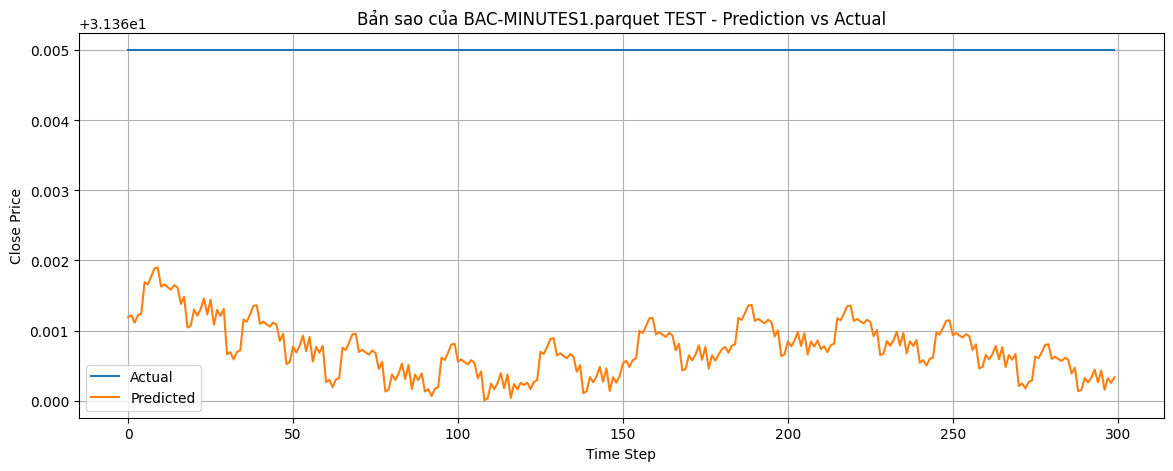


Processing Bản sao của GDX-MINUTES1.parquet (2 of 50)


Training Bản sao của GDX-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:23<00:00, 85.76it/s]


Bản sao của GDX-MINUTES1.parquet - Epoch 1 Train Loss: 0.000566
Bản sao của GDX-MINUTES1.parquet - Epoch 1 VAL MAE: 0.061853
📉 Saved loss log to loss_Bản sao của GDX-MINUTES1.csv


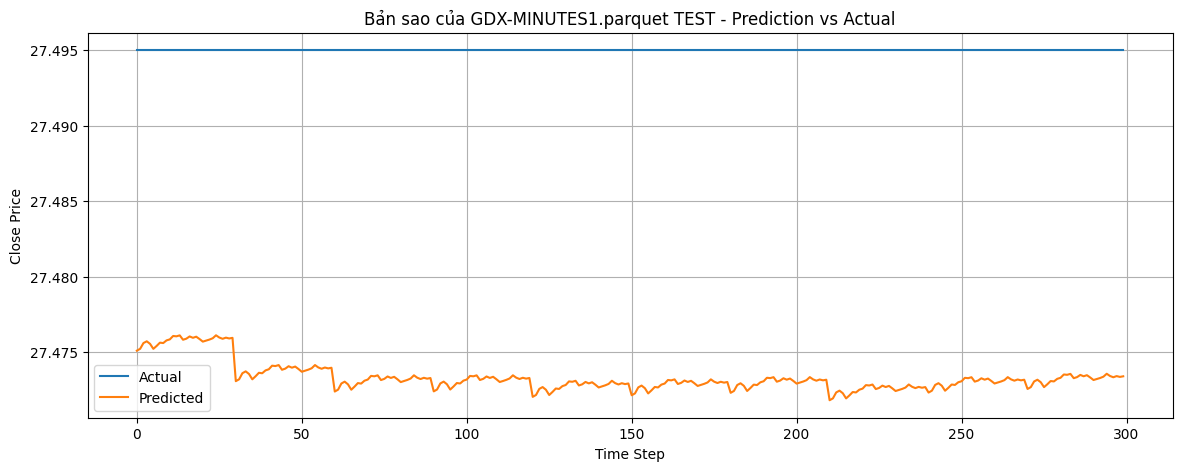


Processing Bản sao của GILD-MINUTES1.parquet (3 of 50)


Training Bản sao của GILD-MINUTES1.parquet - Epoch 1: 100%|██████████| 26888/26888 [05:12<00:00, 86.14it/s]


Bản sao của GILD-MINUTES1.parquet - Epoch 1 Train Loss: 0.002589
Bản sao của GILD-MINUTES1.parquet - Epoch 1 VAL MAE: 0.444971
📉 Saved loss log to loss_Bản sao của GILD-MINUTES1.csv


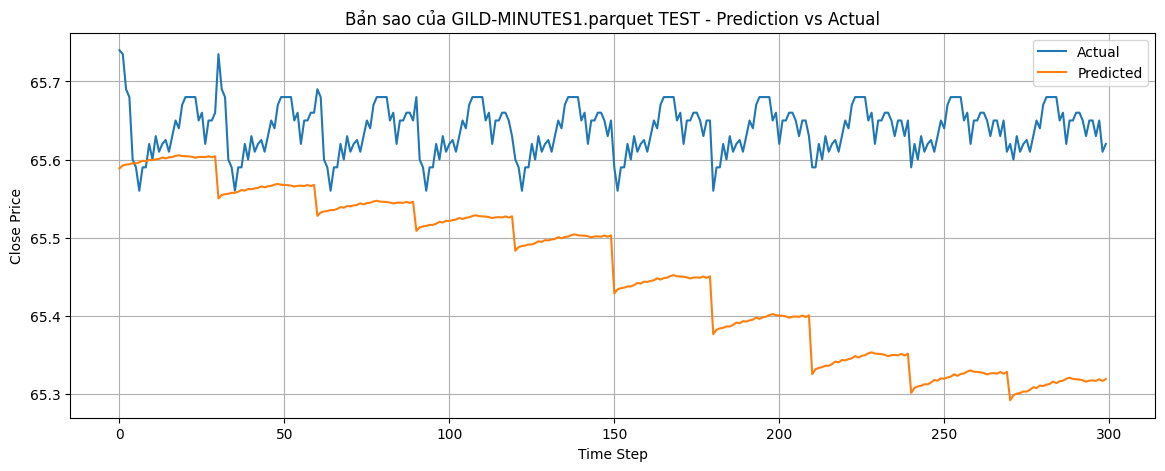


Processing Bản sao của C-MINUTES1.parquet (4 of 50)


Training Bản sao của C-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:27<00:00, 84.65it/s]


Bản sao của C-MINUTES1.parquet - Epoch 1 Train Loss: 0.001426
Bản sao của C-MINUTES1.parquet - Epoch 1 VAL MAE: 0.138643
📉 Saved loss log to loss_Bản sao của C-MINUTES1.csv


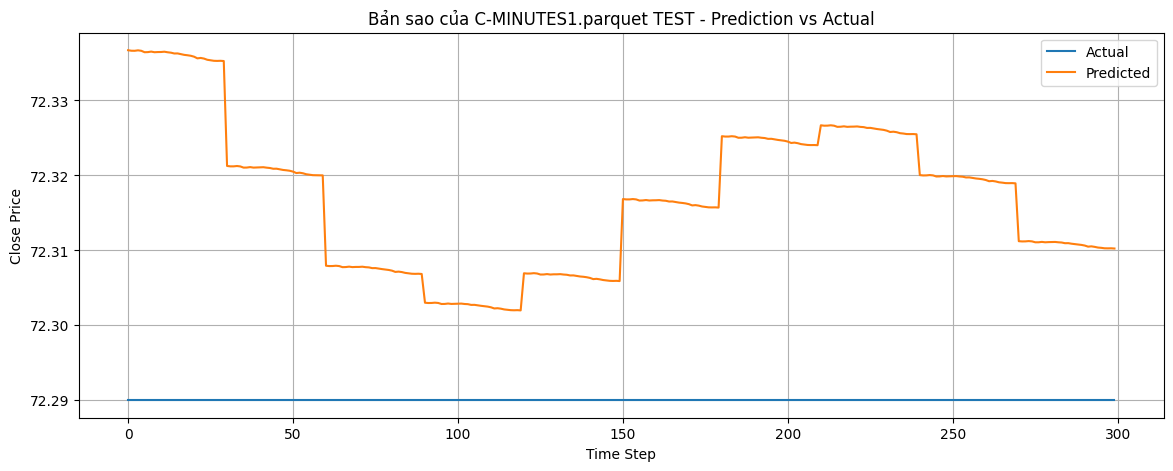


Processing Bản sao của JPM-MINUTES1.parquet (5 of 50)


Training Bản sao của JPM-MINUTES1.parquet - Epoch 1: 100%|██████████| 26888/26888 [05:18<00:00, 84.53it/s]


Bản sao của JPM-MINUTES1.parquet - Epoch 1 Train Loss: 0.000782
Bản sao của JPM-MINUTES1.parquet - Epoch 1 VAL MAE: 0.597097
📉 Saved loss log to loss_Bản sao của JPM-MINUTES1.csv


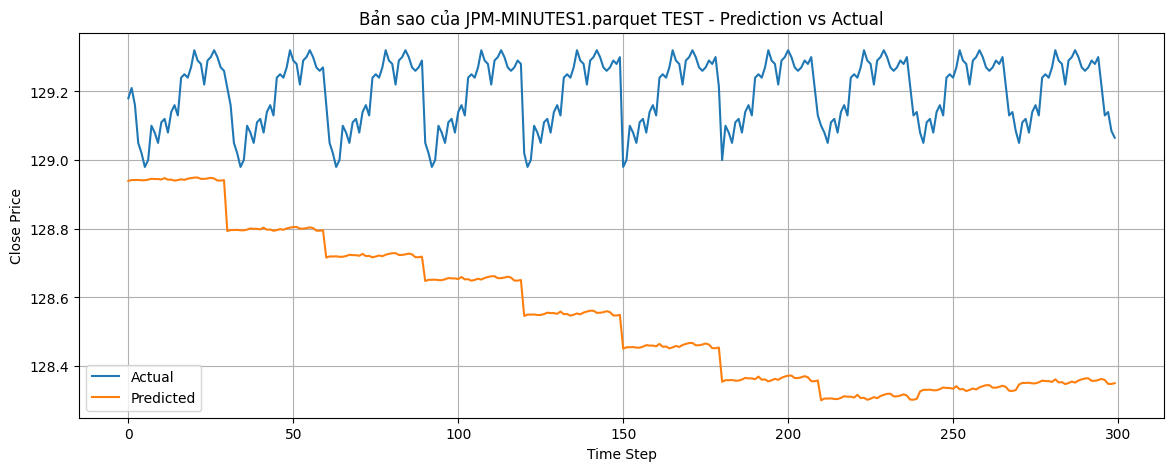


Processing Bản sao của AAPL-MINUTES1.parquet (6 of 50)


Training Bản sao của AAPL-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:26<00:00, 84.89it/s]


Bản sao của AAPL-MINUTES1.parquet - Epoch 1 Train Loss: 0.195381
Bản sao của AAPL-MINUTES1.parquet - Epoch 1 VAL MAE: 0.383784
📉 Saved loss log to loss_Bản sao của AAPL-MINUTES1.csv


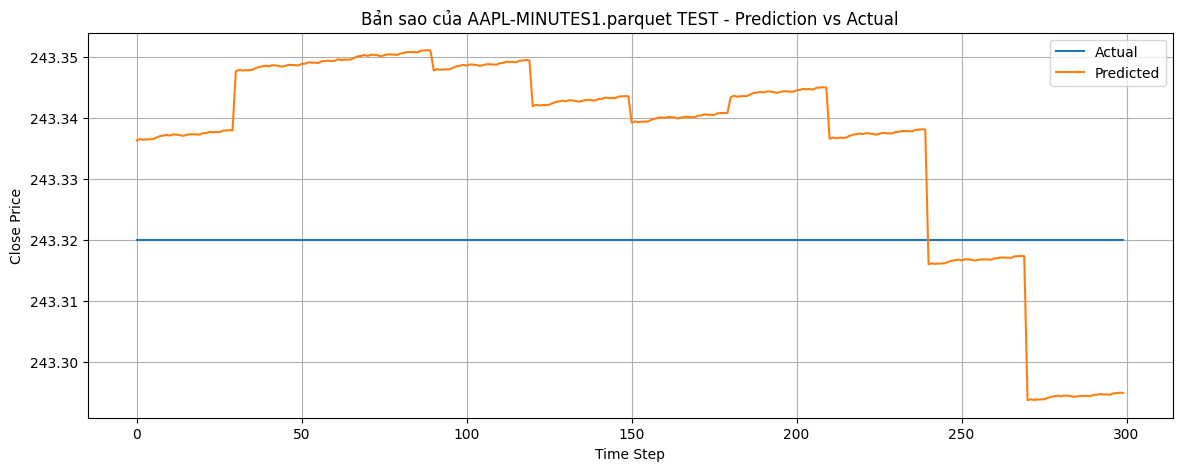


Processing Bản sao của VTRS-MINUTES1.parquet (7 of 50)


Training Bản sao của VTRS-MINUTES1.parquet - Epoch 1: 100%|██████████| 66/66 [00:00<00:00, 86.02it/s]


Bản sao của VTRS-MINUTES1.parquet - Epoch 1 Train Loss: 0.000532
Bản sao của VTRS-MINUTES1.parquet - Epoch 1 VAL MAE: 0.061080
📉 Saved loss log to loss_Bản sao của VTRS-MINUTES1.csv


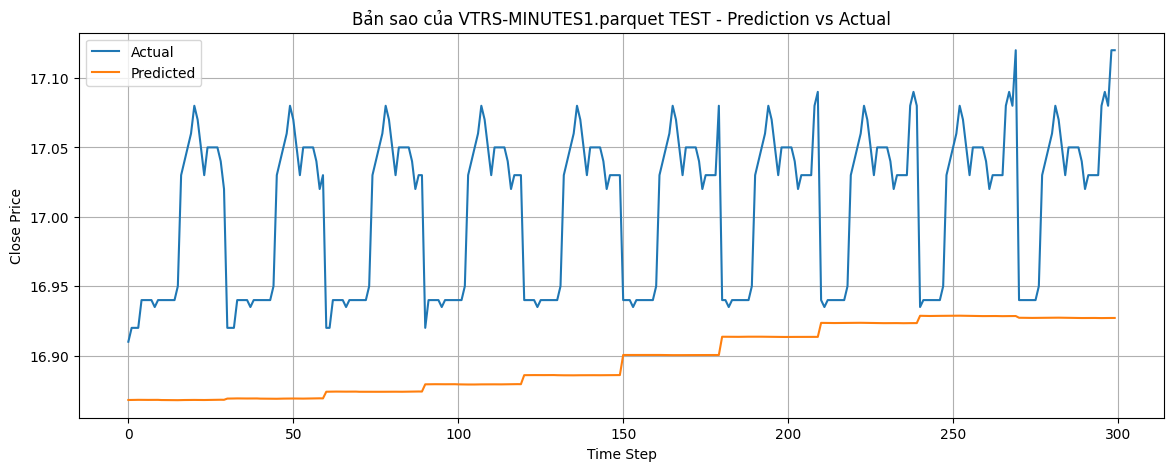


Processing Bản sao của ATVI-MINUTES1.parquet (8 of 50)


Training Bản sao của ATVI-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:27<00:00, 84.71it/s]


Bản sao của ATVI-MINUTES1.parquet - Epoch 1 Train Loss: 0.000363
Bản sao của ATVI-MINUTES1.parquet - Epoch 1 VAL MAE: 0.306337
📉 Saved loss log to loss_Bản sao của ATVI-MINUTES1.csv


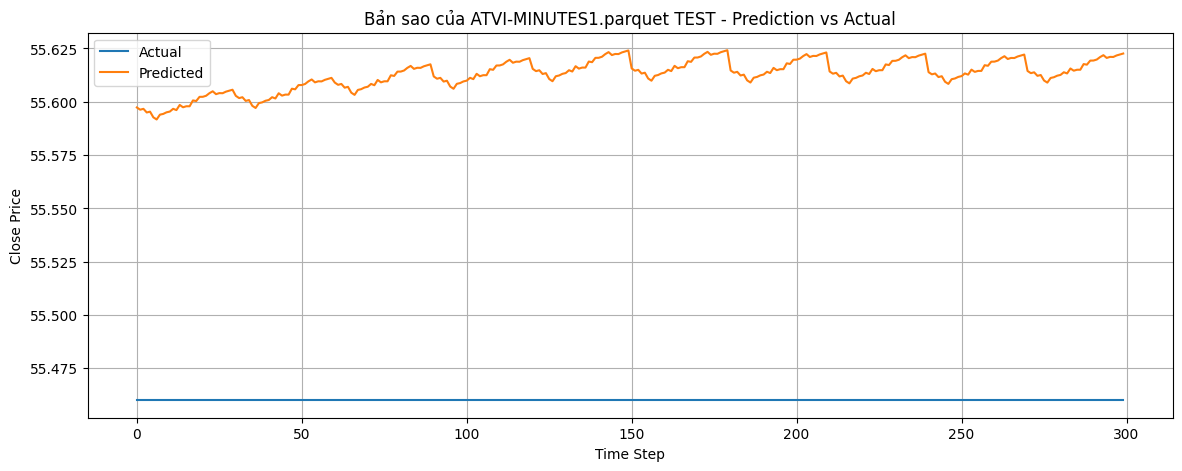


Processing Bản sao của SPY-MINUTES1.parquet (9 of 50)


Training Bản sao của SPY-MINUTES1.parquet - Epoch 1: 100%|██████████| 27658/27658 [05:27<00:00, 84.47it/s]


Bản sao của SPY-MINUTES1.parquet - Epoch 1 Train Loss: 0.002750
Bản sao của SPY-MINUTES1.parquet - Epoch 1 VAL MAE: 0.320275
📉 Saved loss log to loss_Bản sao của SPY-MINUTES1.csv


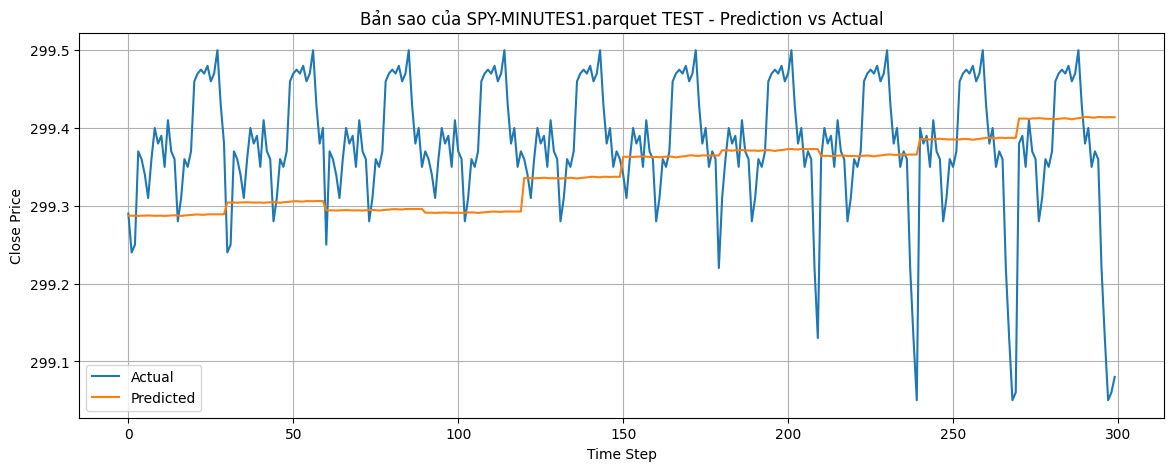


Processing Bản sao của DIS-MINUTES1.parquet (10 of 50)


Training Bản sao của DIS-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:29<00:00, 84.09it/s]


Bản sao của DIS-MINUTES1.parquet - Epoch 1 Train Loss: 0.000926
Bản sao của DIS-MINUTES1.parquet - Epoch 1 VAL MAE: 0.723369
📉 Saved loss log to loss_Bản sao của DIS-MINUTES1.csv


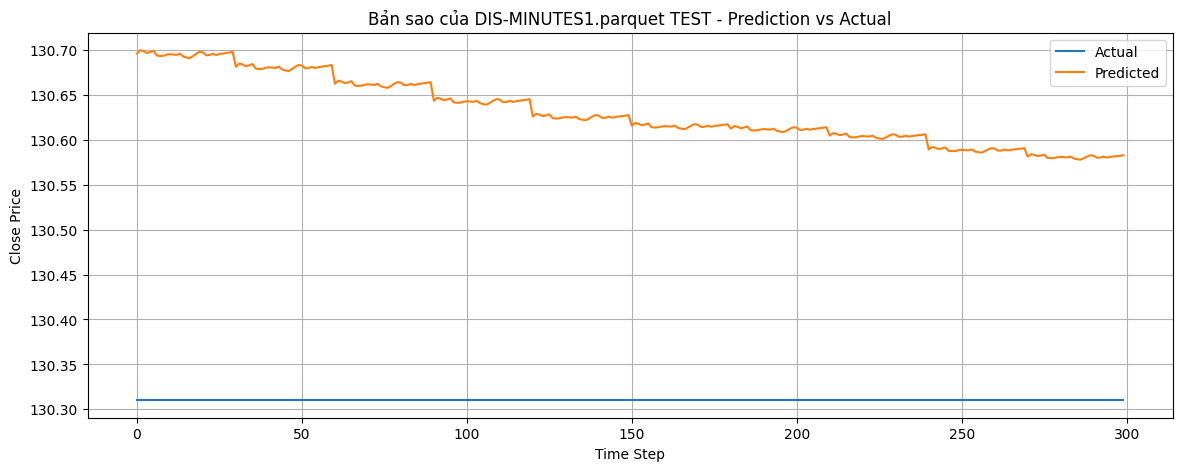


Processing Bản sao của AMAT-MINUTES1.parquet (11 of 50)


Training Bản sao của AMAT-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:28<00:00, 84.45it/s]


Bản sao của AMAT-MINUTES1.parquet - Epoch 1 Train Loss: 0.000253
Bản sao của AMAT-MINUTES1.parquet - Epoch 1 VAL MAE: 0.395456
📉 Saved loss log to loss_Bản sao của AMAT-MINUTES1.csv


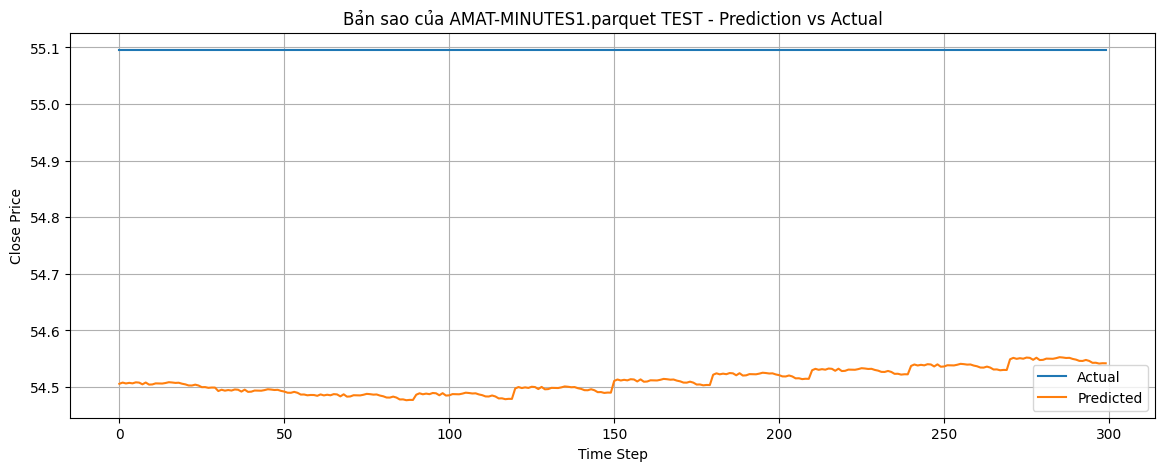


Processing Bản sao của KO-MINUTES1.parquet (12 of 50)


Training Bản sao của KO-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:29<00:00, 84.03it/s]


Bản sao của KO-MINUTES1.parquet - Epoch 1 Train Loss: 0.001031
Bản sao của KO-MINUTES1.parquet - Epoch 1 VAL MAE: 0.058090
📉 Saved loss log to loss_Bản sao của KO-MINUTES1.csv


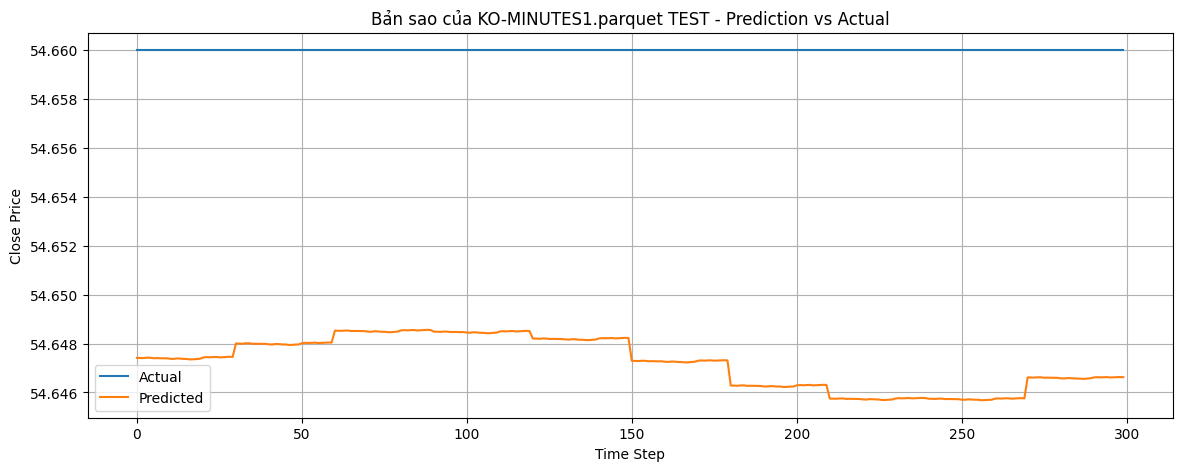


Processing Bản sao của JNJ-MINUTES1.parquet (13 of 50)


Training Bản sao của JNJ-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:37<00:00, 82.05it/s]


Bản sao của JNJ-MINUTES1.parquet - Epoch 1 Train Loss: 0.000770
Bản sao của JNJ-MINUTES1.parquet - Epoch 1 VAL MAE: 0.175462
📉 Saved loss log to loss_Bản sao của JNJ-MINUTES1.csv


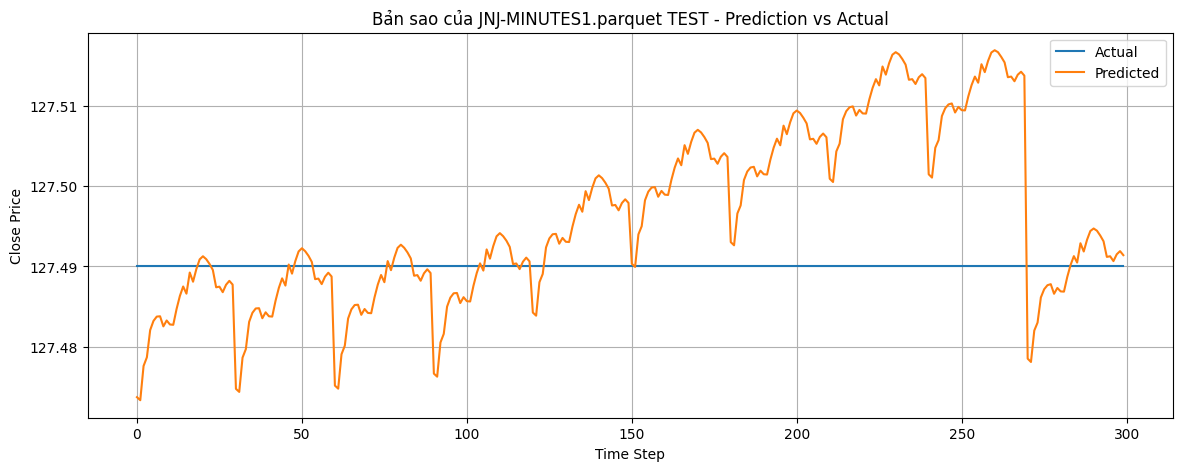


Processing Bản sao của CVX-MINUTES1.parquet (14 of 50)


Training Bản sao của CVX-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:41<00:00, 81.19it/s]


Bản sao của CVX-MINUTES1.parquet - Epoch 1 Train Loss: 0.001839
Bản sao của CVX-MINUTES1.parquet - Epoch 1 VAL MAE: 0.804319
📉 Saved loss log to loss_Bản sao của CVX-MINUTES1.csv


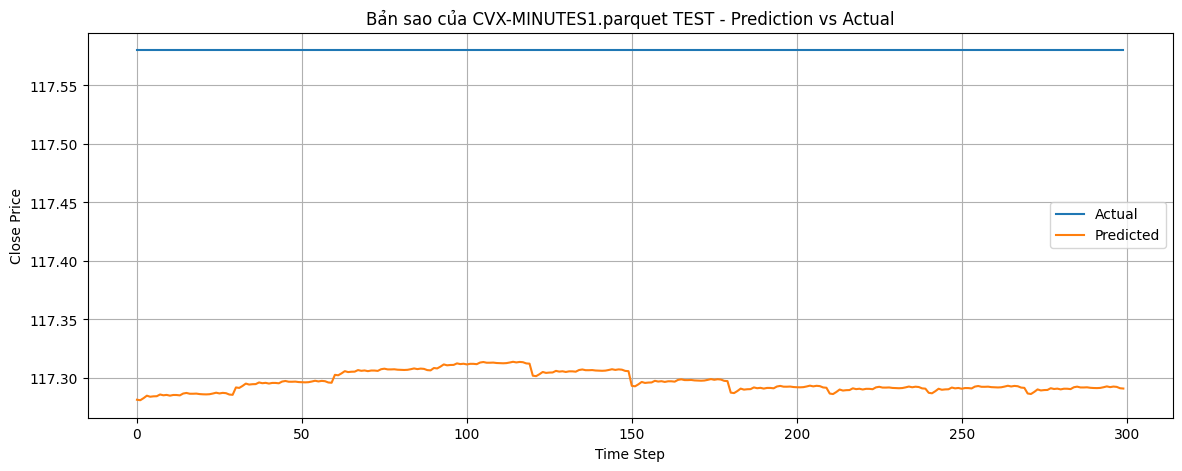


Processing Bản sao của BA-MINUTES1.parquet (15 of 50)


Training Bản sao của BA-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:34<00:00, 82.76it/s]


Bản sao của BA-MINUTES1.parquet - Epoch 1 Train Loss: 0.005746
Bản sao của BA-MINUTES1.parquet - Epoch 1 VAL MAE: 2.353989
📉 Saved loss log to loss_Bản sao của BA-MINUTES1.csv


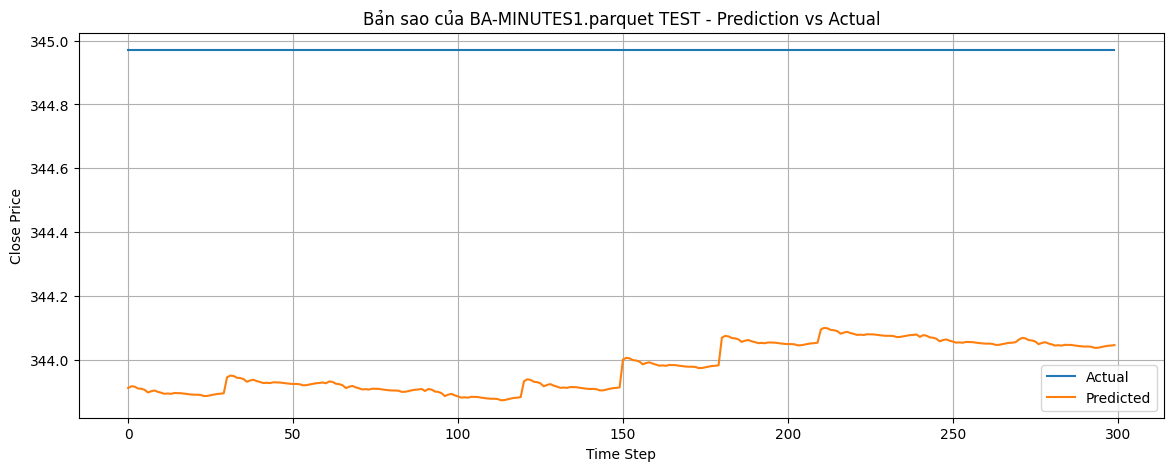


Processing Bản sao của EEM-MINUTES1.parquet (16 of 50)


Training Bản sao của EEM-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:33<00:00, 83.07it/s]


Bản sao của EEM-MINUTES1.parquet - Epoch 1 Train Loss: 0.003952
Bản sao của EEM-MINUTES1.parquet - Epoch 1 VAL MAE: 0.047970
✅ Saved better model!
📉 Saved loss log to loss_Bản sao của EEM-MINUTES1.csv


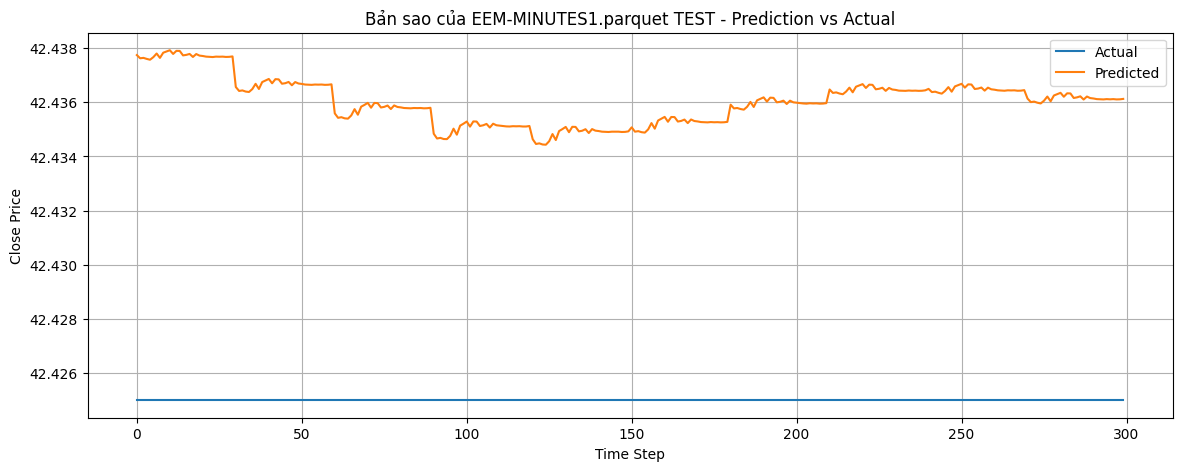


Processing Bản sao của INTC-MINUTES1.parquet (17 of 50)


Training Bản sao của INTC-MINUTES1.parquet - Epoch 1: 100%|██████████| 26888/26888 [05:24<00:00, 82.96it/s]


Bản sao của INTC-MINUTES1.parquet - Epoch 1 Train Loss: 0.000242
Bản sao của INTC-MINUTES1.parquet - Epoch 1 VAL MAE: 0.173783
📉 Saved loss log to loss_Bản sao của INTC-MINUTES1.csv


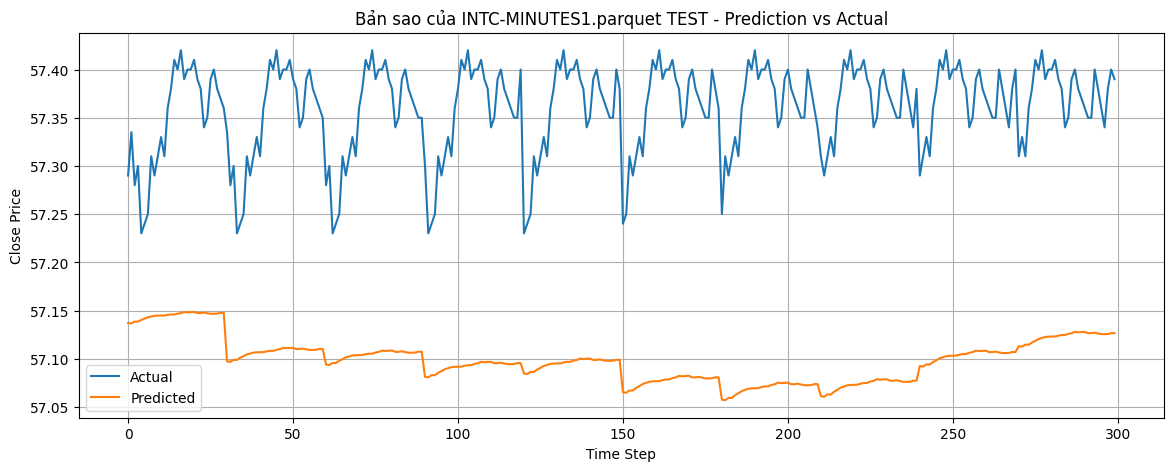


Processing Bản sao của EFA-MINUTES1.parquet (18 of 50)


Training Bản sao của EFA-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:35<00:00, 82.50it/s]


Bản sao của EFA-MINUTES1.parquet - Epoch 1 Train Loss: 0.002694
Bản sao của EFA-MINUTES1.parquet - Epoch 1 VAL MAE: 0.052032
📉 Saved loss log to loss_Bản sao của EFA-MINUTES1.csv


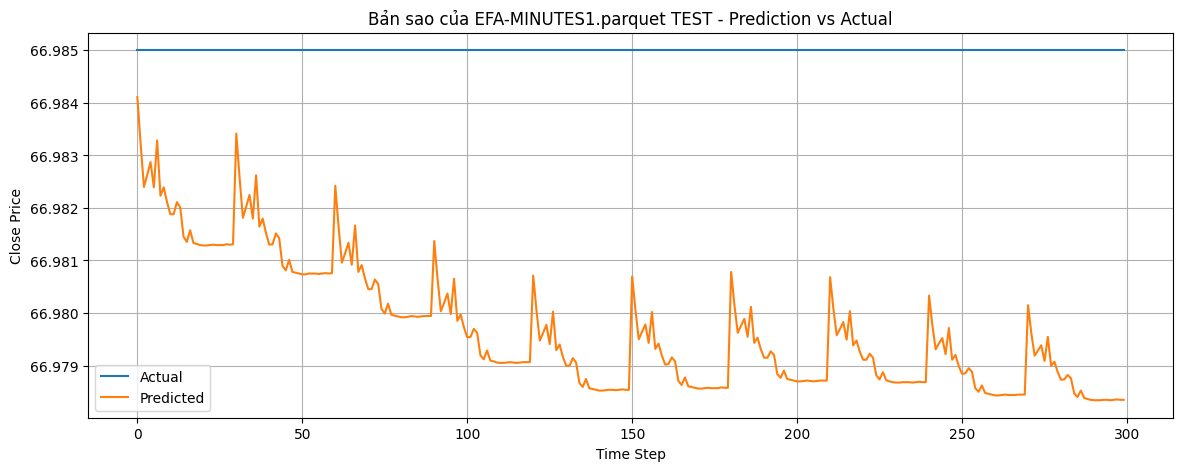


Processing Bản sao của CSCO-MINUTES1.parquet (19 of 50)


Training Bản sao của CSCO-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:37<00:00, 82.13it/s]


Bản sao của CSCO-MINUTES1.parquet - Epoch 1 Train Loss: 0.000161
Bản sao của CSCO-MINUTES1.parquet - Epoch 1 VAL MAE: 0.157881
📉 Saved loss log to loss_Bản sao của CSCO-MINUTES1.csv


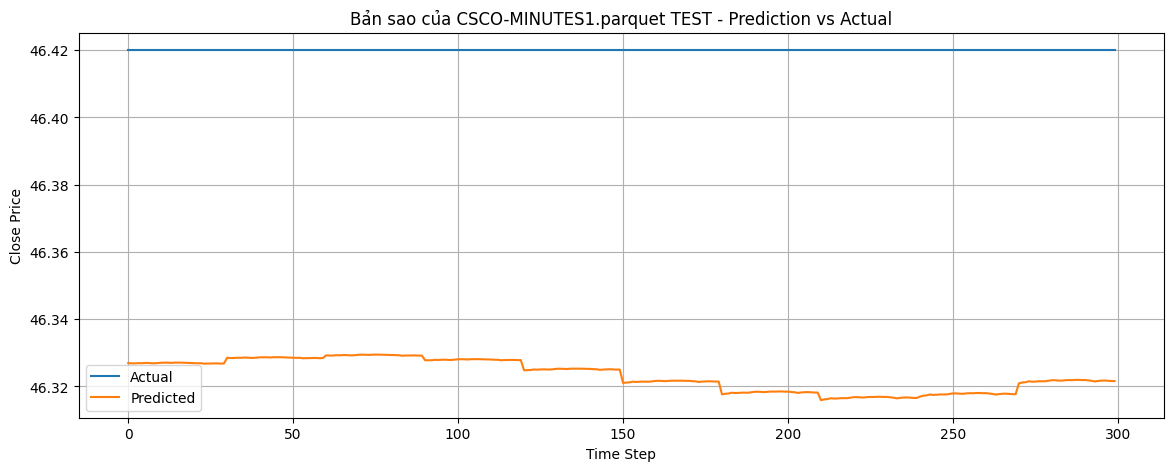


Processing Bản sao của EXC-MINUTES1.parquet (20 of 50)


Training Bản sao của EXC-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:37<00:00, 82.14it/s]


Bản sao của EXC-MINUTES1.parquet - Epoch 1 Train Loss: 0.000206
Bản sao của EXC-MINUTES1.parquet - Epoch 1 VAL MAE: 0.066057
📉 Saved loss log to loss_Bản sao của EXC-MINUTES1.csv


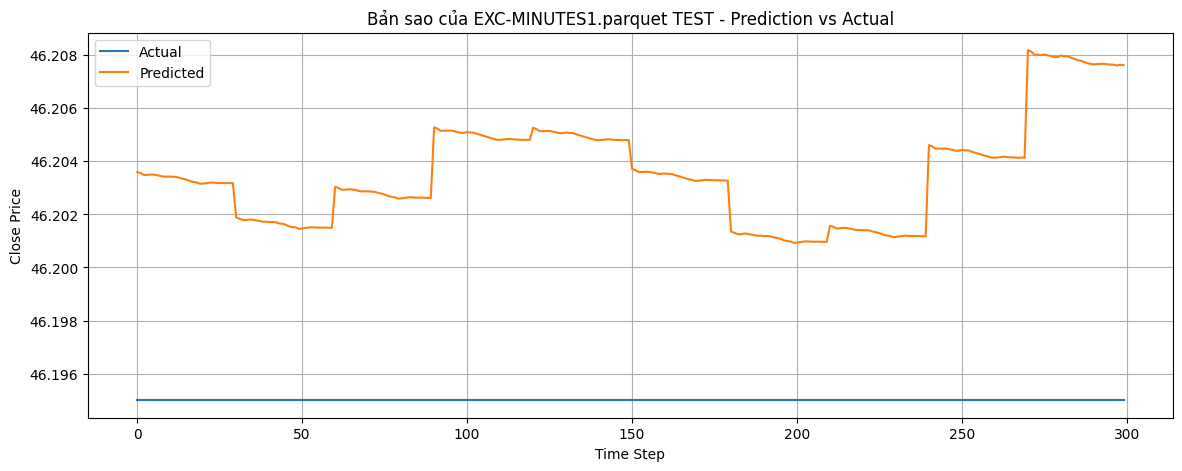


Processing Bản sao của CAT-MINUTES1.parquet (21 of 50)


Training Bản sao của CAT-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:39<00:00, 81.66it/s]


Bản sao của CAT-MINUTES1.parquet - Epoch 1 Train Loss: 0.002584
Bản sao của CAT-MINUTES1.parquet - Epoch 1 VAL MAE: 2.044043
📉 Saved loss log to loss_Bản sao của CAT-MINUTES1.csv


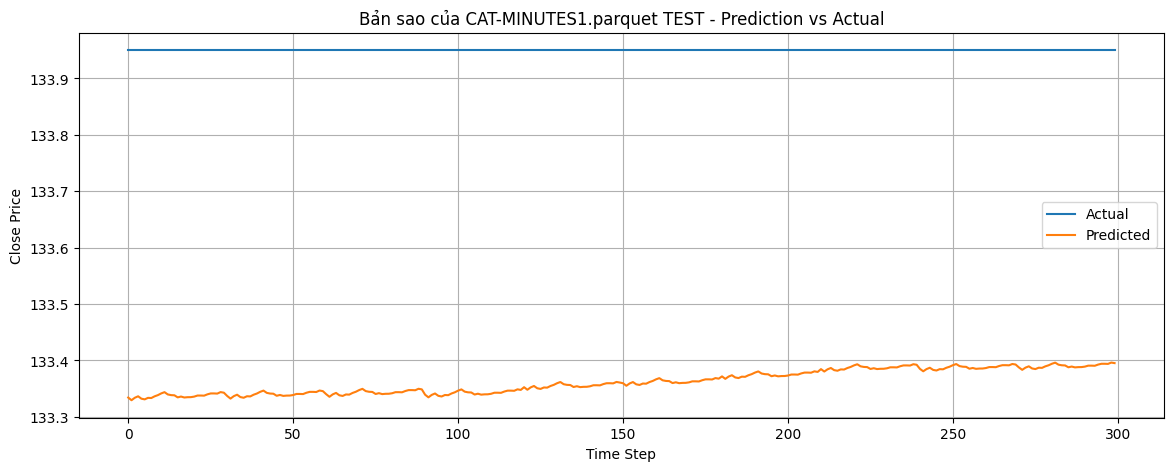


Processing Bản sao của MU-MINUTES1.parquet (22 of 50)


Training Bản sao của MU-MINUTES1.parquet - Epoch 1: 100%|██████████| 23690/23690 [04:52<00:00, 81.04it/s]


Bản sao của MU-MINUTES1.parquet - Epoch 1 Train Loss: 0.000508
Bản sao của MU-MINUTES1.parquet - Epoch 1 VAL MAE: 0.638873
📉 Saved loss log to loss_Bản sao của MU-MINUTES1.csv


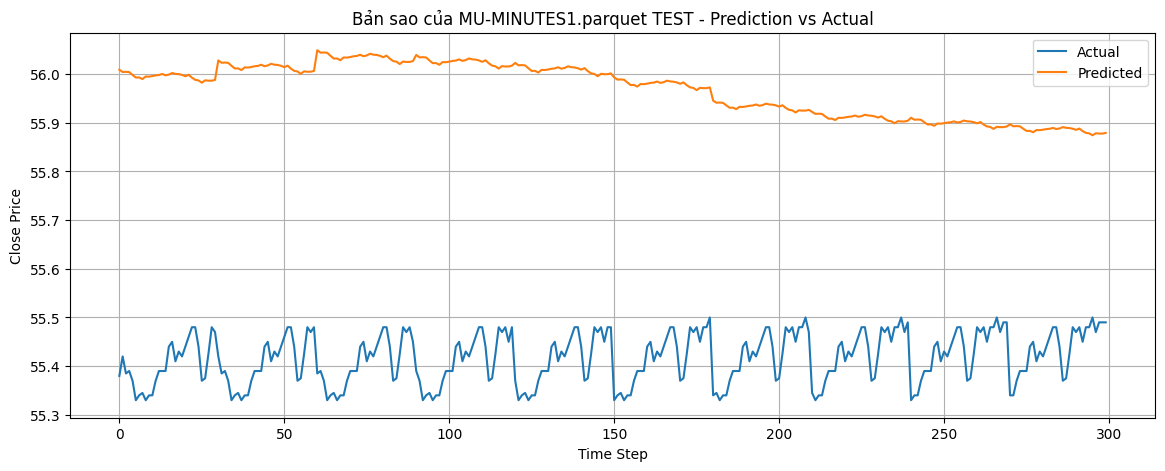


Processing Bản sao của HD-MINUTES1.parquet (23 of 50)


Training Bản sao của HD-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:44<00:00, 80.35it/s]


Bản sao của HD-MINUTES1.parquet - Epoch 1 Train Loss: 0.001394
Bản sao của HD-MINUTES1.parquet - Epoch 1 VAL MAE: 0.713963
📉 Saved loss log to loss_Bản sao của HD-MINUTES1.csv


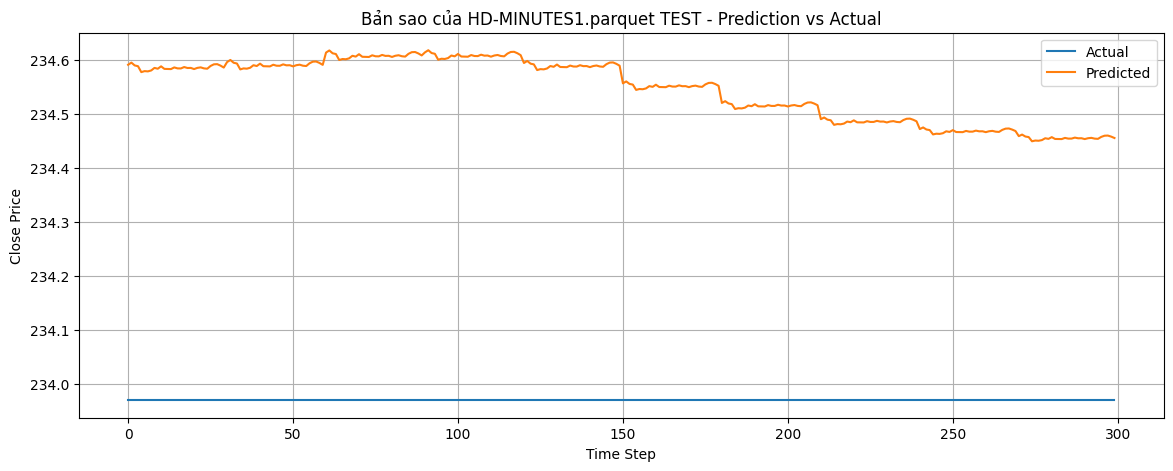


Processing Bản sao của VNQ-MINUTES1.parquet (24 of 50)


Training Bản sao của VNQ-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:47<00:00, 79.78it/s]


Bản sao của VNQ-MINUTES1.parquet - Epoch 1 Train Loss: 0.000507
Bản sao của VNQ-MINUTES1.parquet - Epoch 1 VAL MAE: 0.101084
📉 Saved loss log to loss_Bản sao của VNQ-MINUTES1.csv


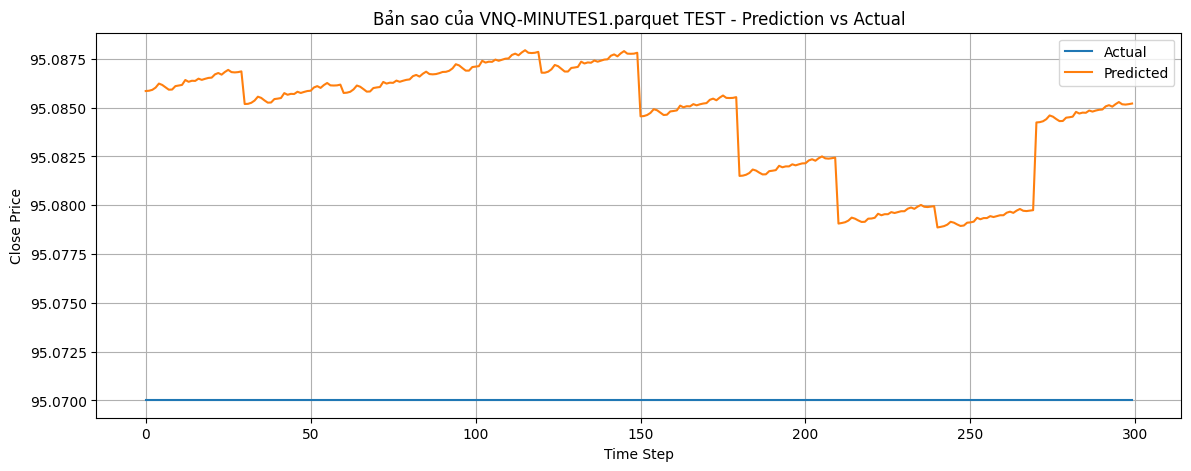


Processing Bản sao của BIDU-MINUTES1.parquet (25 of 50)


Training Bản sao của BIDU-MINUTES1.parquet - Epoch 1: 100%|██████████| 27707/27707 [05:49<00:00, 79.34it/s]


Bản sao của BIDU-MINUTES1.parquet - Epoch 1 Train Loss: 0.246413
Bản sao của BIDU-MINUTES1.parquet - Epoch 1 VAL MAE: 0.374579
📉 Saved loss log to loss_Bản sao của BIDU-MINUTES1.csv


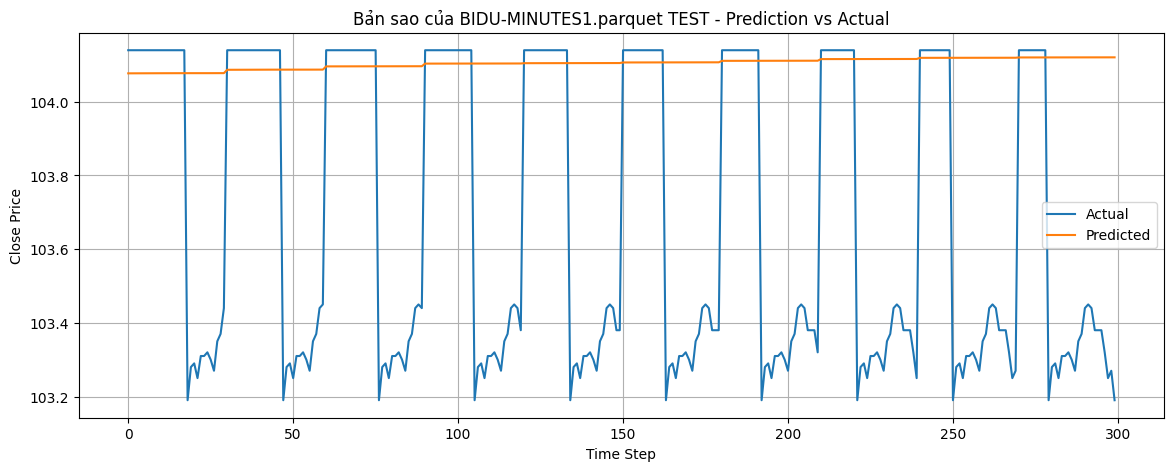


Processing Bản sao của GM-MINUTES1.parquet (26 of 50)


Training Bản sao của GM-MINUTES1.parquet - Epoch 1: 100%|██████████| 24109/24109 [05:04<00:00, 79.09it/s]


Bản sao của GM-MINUTES1.parquet - Epoch 1 Train Loss: 0.000313
Bản sao của GM-MINUTES1.parquet - Epoch 1 VAL MAE: 0.067418
📉 Saved loss log to loss_Bản sao của GM-MINUTES1.csv


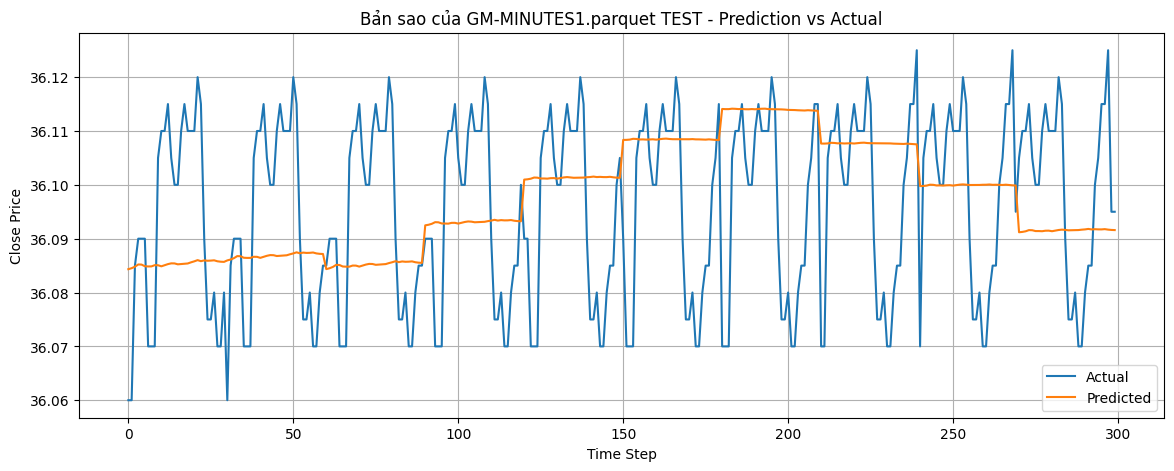


Processing Bản sao của IBM-MINUTES1.parquet (27 of 50)


Training Bản sao của IBM-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:52<00:00, 78.61it/s]


Bản sao của IBM-MINUTES1.parquet - Epoch 1 Train Loss: 0.003790
Bản sao của IBM-MINUTES1.parquet - Epoch 1 VAL MAE: 0.713228
📉 Saved loss log to loss_Bản sao của IBM-MINUTES1.csv


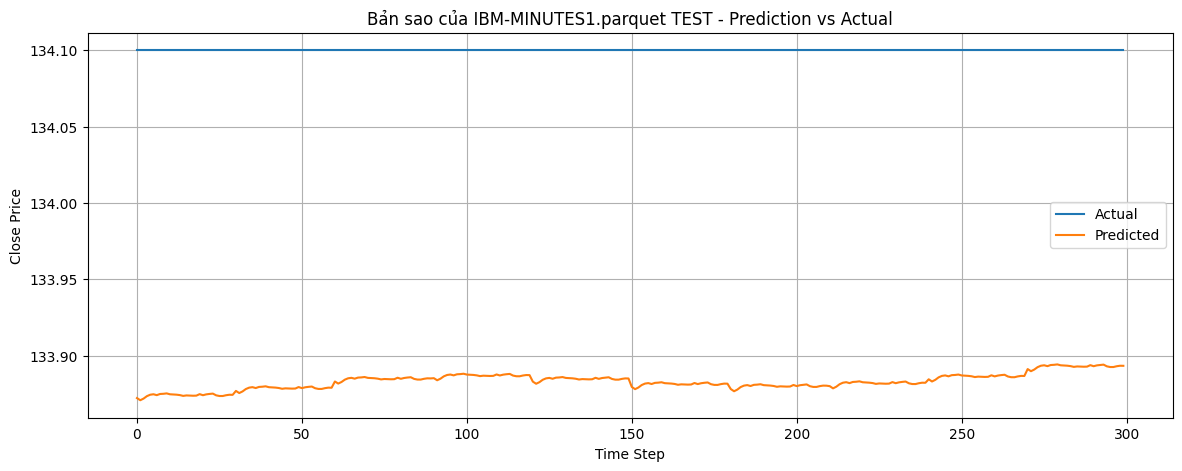


Processing Bản sao của AXP-MINUTES1.parquet (28 of 50)


Training Bản sao của AXP-MINUTES1.parquet - Epoch 1: 100%|██████████| 27454/27454 [05:49<00:00, 78.48it/s]


Bản sao của AXP-MINUTES1.parquet - Epoch 1 Train Loss: 0.000820
Bản sao của AXP-MINUTES1.parquet - Epoch 1 VAL MAE: 0.357692
📉 Saved loss log to loss_Bản sao của AXP-MINUTES1.csv


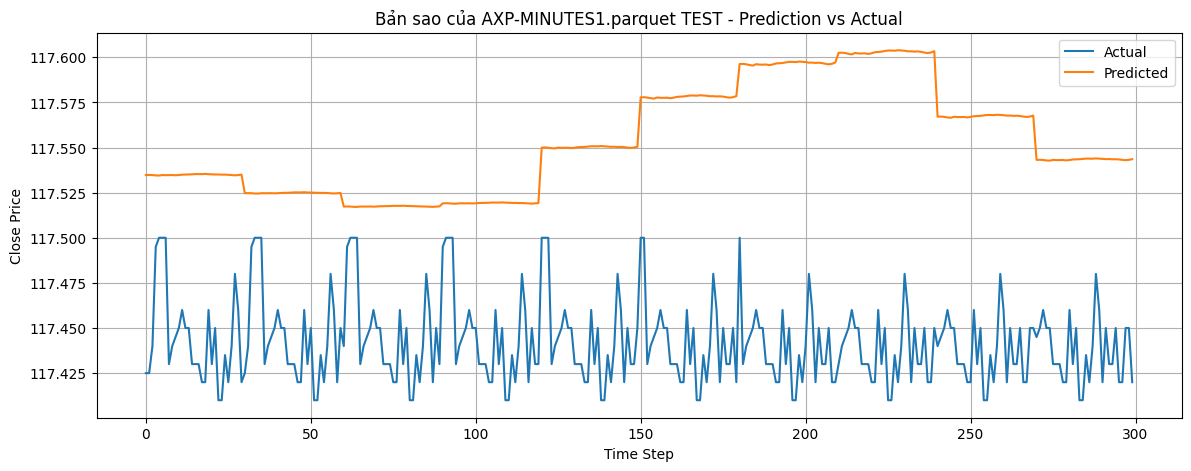


Processing Bản sao của AIG-MINUTES1.parquet (29 of 50)


Training Bản sao của AIG-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:52<00:00, 78.56it/s]


Bản sao của AIG-MINUTES1.parquet - Epoch 1 Train Loss: 0.000628
Bản sao của AIG-MINUTES1.parquet - Epoch 1 VAL MAE: 0.102102
📉 Saved loss log to loss_Bản sao của AIG-MINUTES1.csv


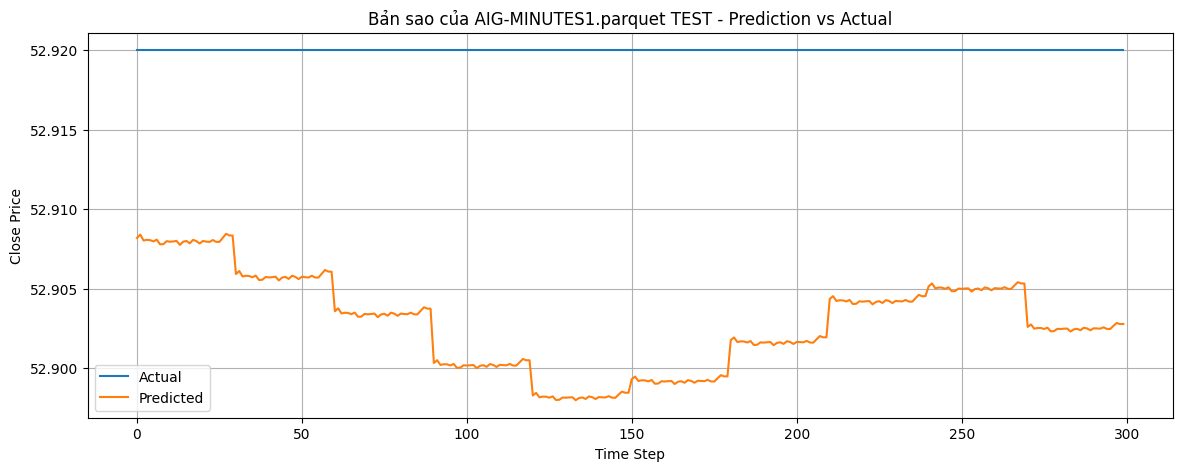


Processing Bản sao của APC-MINUTES1.parquet (30 of 50)


Training Bản sao của APC-MINUTES1.parquet - Epoch 1: 100%|██████████| 24412/24412 [05:13<00:00, 77.77it/s]


Bản sao của APC-MINUTES1.parquet - Epoch 1 Train Loss: 0.002444
Bản sao của APC-MINUTES1.parquet - Epoch 1 VAL MAE: 0.620202
📉 Saved loss log to loss_Bản sao của APC-MINUTES1.csv


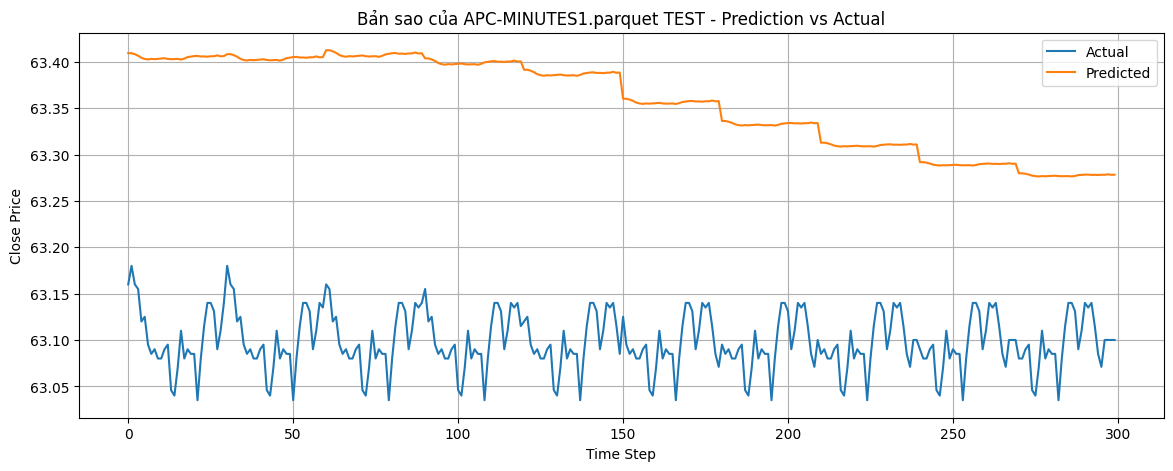


Processing Bản sao của NVDA-MINUTES1.parquet (31 of 50)


Training Bản sao của NVDA-MINUTES1.parquet - Epoch 1: 100%|██████████| 23827/23827 [05:03<00:00, 78.53it/s]


Bản sao của NVDA-MINUTES1.parquet - Epoch 1 Train Loss: 0.007242
Bản sao của NVDA-MINUTES1.parquet - Epoch 1 VAL MAE: 0.830935
📉 Saved loss log to loss_Bản sao của NVDA-MINUTES1.csv


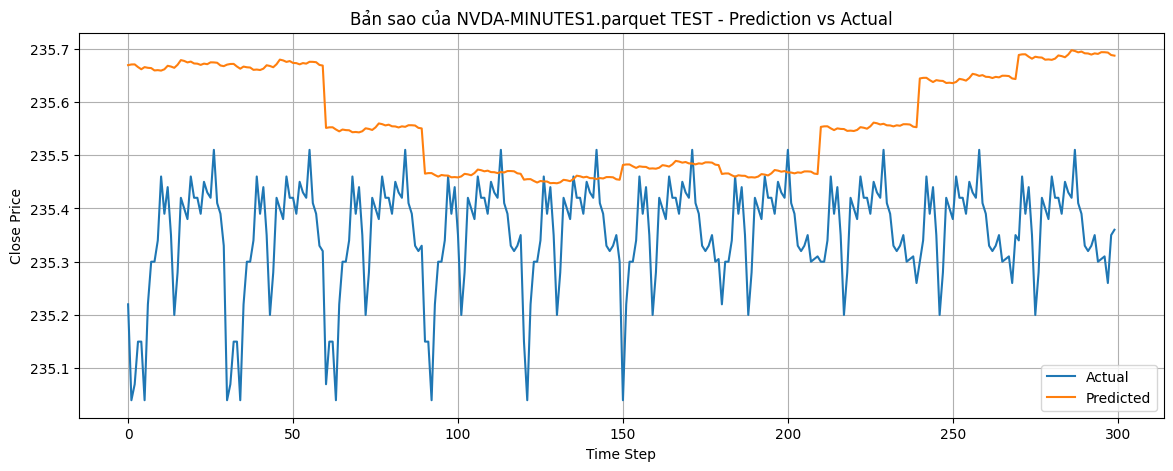


Processing Bản sao của GS-MINUTES1.parquet (32 of 50)


Training Bản sao của GS-MINUTES1.parquet - Epoch 1: 100%|██████████| 27717/27717 [05:49<00:00, 79.21it/s]


Bản sao của GS-MINUTES1.parquet - Epoch 1 Train Loss: 0.006461
Bản sao của GS-MINUTES1.parquet - Epoch 1 VAL MAE: 1.615338
📉 Saved loss log to loss_Bản sao của GS-MINUTES1.csv


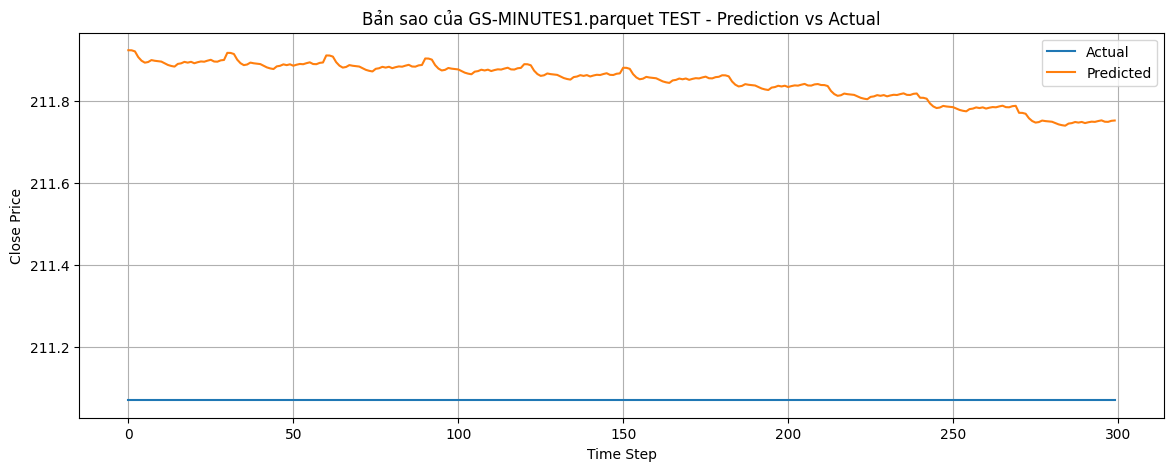


Processing Bản sao của XOM-MINUTES1.parquet (33 of 50)


Training Bản sao của XOM-MINUTES1.parquet - Epoch 1: 100%|██████████| 25873/25873 [05:30<00:00, 78.36it/s]


Bản sao của XOM-MINUTES1.parquet - Epoch 1 Train Loss: 0.000889
Bản sao của XOM-MINUTES1.parquet - Epoch 1 VAL MAE: 0.467841
📉 Saved loss log to loss_Bản sao của XOM-MINUTES1.csv


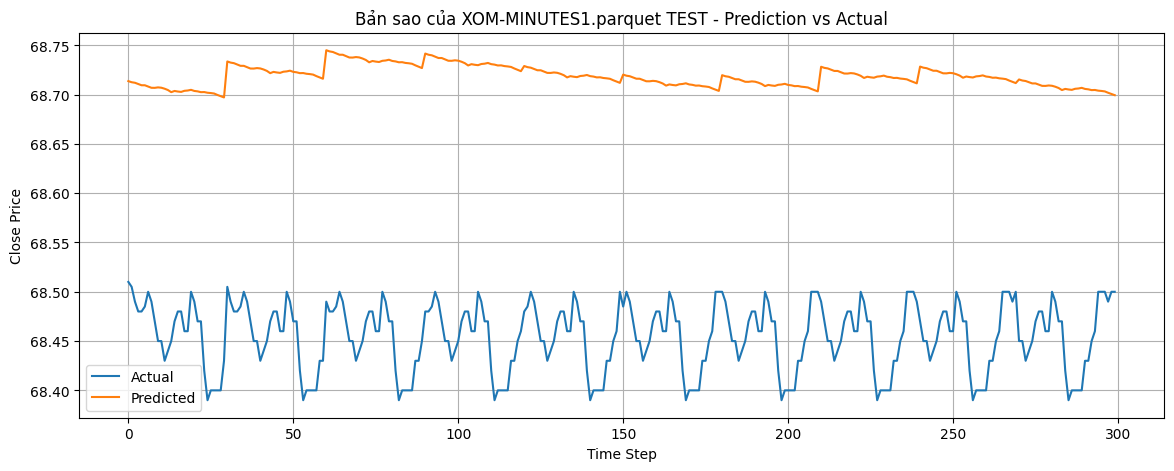


Processing Bản sao của BMY-MINUTES1.parquet (34 of 50)


Training Bản sao của BMY-MINUTES1.parquet - Epoch 1:  86%|████████▌ | 23830/27717 [05:04<00:49, 78.21it/s]


KeyboardInterrupt: 

In [3]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from transformers import PatchTSTConfig, PatchTSTForPrediction
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

# ===== Dataset Definition =====
class TimeSeriesDataset(Dataset):
    def __init__(self, series, context_length, prediction_length):
        self.series = series
        self.context_length = context_length
        self.prediction_length = prediction_length

    def __len__(self):
        return len(self.series) - self.context_length - self.prediction_length

    def __getitem__(self, idx):
        x = self.series[idx : idx + self.context_length]
        y = self.series[idx + self.context_length : idx + self.context_length + self.prediction_length]
        return {
            'past_values': torch.tensor(x, dtype=torch.float),
            'future_values': torch.tensor(y, dtype=torch.float),
        }

# ===== Training Function =====
def train_on_single_file(file_path, model, scaler, device, config,
                         context_length=60, prediction_length=30,
                         epochs=1, batch_size=32, best_mae=np.inf):
    try:
        # Load and preprocess data
        df = pd.read_parquet(file_path)
        series = df['close'].dropna().values.reshape(-1, 1)

        # Train/test/val split
        train_size = int(0.8 * len(series))
        val_size = int(0.1 * len(series))
        test_size = len(series) - train_size - val_size

        train_series = series[:train_size]
        val_series = series[train_size:train_size + val_size]
        test_series = series[train_size + val_size:]

        # Fit scaler once
        if not hasattr(scaler, 'mean_'):
            train_scaled = scaler.fit_transform(train_series)
        else:
            train_scaled = scaler.transform(train_series)

        val_scaled = scaler.transform(val_series)
        test_scaled = scaler.transform(test_series)

        # Datasets
        train_dataset = TimeSeriesDataset(train_scaled, context_length, prediction_length)
        val_dataset = TimeSeriesDataset(val_scaled, context_length, prediction_length)
        test_dataset = TimeSeriesDataset(test_scaled, context_length, prediction_length)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
        loss_fn = torch.nn.MSELoss()

        # === Khởi tạo danh sách để lưu loss ===
        history = {
            'epoch': [],
            'train_loss': [],
            'val_mae': []
        }

        for epoch in range(epochs):
            model.train()
            total_loss = 0
            for batch in tqdm(train_loader, desc=f"Training {os.path.basename(file_path)} - Epoch {epoch+1}"):
                x = batch['past_values'].to(device)
                y = batch['future_values'].to(device)

                outputs = model(past_values=x)
                pred = outputs.prediction_outputs
                loss = loss_fn(pred, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            print(f"{os.path.basename(file_path)} - Epoch {epoch+1} Train Loss: {avg_loss:.6f}")

            val_mae = evaluate_model(model, val_loader, scaler, device, name=f"{os.path.basename(file_path)} VAL", show_plot=False)
            print(f"{os.path.basename(file_path)} - Epoch {epoch+1} VAL MAE: {val_mae:.6f}")

            # === Ghi log ===
            history['epoch'].append(epoch + 1)
            history['train_loss'].append(avg_loss)
            history['val_mae'].append(val_mae)

            # Save best model
            if val_mae < best_mae:
                best_mae = val_mae
                torch.save(model.state_dict(), f"best_model_{os.path.basename(file_path)}.pt")
                print("✅ Saved better model!")

        # === Lưu log ra file CSV ===
        loss_df = pd.DataFrame(history)
        loss_file = f"loss_{os.path.splitext(os.path.basename(file_path))[0]}.csv"
        loss_df.to_csv(loss_file, index=False)
        print(f"📉 Saved loss log to {loss_file}")

        # Final test evaluation
        evaluate_model(model, test_loader, scaler, device, name=f"{os.path.basename(file_path)} TEST")

        return model, best_mae

    except Exception as e:
        print(f"❌ Error processing {file_path}: {str(e)}")
        return model, best_mae
    finally:
        del df, series, train_series, val_series, test_series
        gc.collect()

# ===== Evaluation Function =====
def evaluate_model(model, loader, scaler, device, name="Evaluation", show_plot=True):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            x = batch['past_values'].to(device)
            y = batch['future_values'].to(device)
            output = model(past_values=x).prediction_outputs
            preds.append(output.cpu().numpy())
            trues.append(y.cpu().numpy())

    if not preds:
        print(f"No predictions for {name}")
        return np.inf

    preds = np.concatenate(preds)
    trues = np.concatenate(trues)

    preds_inv = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
    trues_inv = scaler.inverse_transform(trues.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(trues_inv, preds_inv)

    if show_plot:
        plt.figure(figsize=(14, 5))
        plt.plot(trues_inv[:300], label='Actual')
        plt.plot(preds_inv[:300], label='Predicted')
        plt.title(f'{name} - Prediction vs Actual')
        plt.xlabel('Time Step')
        plt.ylabel('Close Price')
        plt.legend()
        plt.grid(True)
        plt.show()

    return mae


# ===== Main Training Loop =====
def main():
    # Configs
    context_length = 60
    prediction_length = 30
    batch_size = 32
    epochs_per_file = 1

    config = PatchTSTConfig(
        context_length=context_length,
        prediction_length=prediction_length,
        patch_len=10,
        stride=10,
        d_model=64,
        num_layers=2,
        num_heads=2,
        dropout=0.3,
        target_dim=1,
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PatchTSTForPrediction(config).to(device)
    scaler = StandardScaler()  # will fit on first file

    data_dir = '/content/drive/MyDrive/Draft/TimeSeries/Duong_Parquet/50Demo'
    processed_files = 0
    best_mae = np.inf

    for file_name in os.listdir(data_dir):
        if file_name.endswith('.parquet'):
            file_path = os.path.join(data_dir, file_name)
            print(f"\nProcessing {file_name} ({processed_files + 1} of {len(os.listdir(data_dir))})")

            model, best_mae = train_on_single_file(
                file_path, model, scaler, device, config,
                context_length, prediction_length,
                epochs_per_file, batch_size, best_mae
            )

            processed_files += 1
            gc.collect()

    torch.save(model.state_dict(), "patchtst_model_final.pt")
    print("✅ Training completed on all files.")


# ===== Entry Point =====
if __name__ == "__main__":
    main()
